# Matching up all Argo float porfile with Ox and T/S to Ml CHla and Bbp output

This notebook is a generalization of the workflow from 3d_products.ipynb

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from argopy import ArgoFloat


dat = xr.open_dataset("../Data/Raw/cmems_obs-mob_glo_bgc-chl-poc_my_0.25deg_P7D-m_multi-vars_39.88W-10.12W_58.12N-64.88N_0.00-200.00m_2015-01-07-2023-12-27.nc")

In [2]:
argo_df = pd.read_csv("../Data/Processed/ts_floats_to_match.csv")

In [3]:
argo_df

float_wmo  prof_number        lon        lat        date  depth  \
0         1901210          166 -38.136000  58.003000  2016-02-13      0   
1         1901210          166 -38.136000  58.003000  2016-02-13      1   
2         1901210          166 -38.136000  58.003000  2016-02-13      2   
3         1901210          166 -38.136000  58.003000  2016-02-13      3   
4         1901210          166 -38.136000  58.003000  2016-02-13      4   
...           ...          ...        ...        ...         ...    ...   
775453    7902223           52 -30.606907  61.084361  2025-10-27    196   
775454    7902223           52 -30.606907  61.084361  2025-10-27    197   
775455    7902223           52 -30.606907  61.084361  2025-10-27    198   
775456    7902223           52 -30.606907  61.084361  2025-10-27    199   
775457    7902223           52 -30.606907  61.084361  2025-10-27    200   

            temp        sal  
0       3.944000  34.897999  
1       3.948000  34.893499  
2       3.952000  34.889000  
3       3.953000  34.889000  
4       3.954000  34.889000  
...          ...        ...  
775453  7.438904  35.096630  
775454  7.434623  35.097805  
775455  7.421692  35.096729  
775456  7.412808  35.095915  
775457  7.394007  35.092632  

[775458 rows x 8 columns]

In [4]:
# Bin argo_df by 5m depth intervals per profile (unique float_wmo and prof_number)
# Create depth bins
argo_df['depth_bin'] = (argo_df['depth'] / 5).round().astype(int) * 5

# Group by float_wmo, prof_number, and depth_bin, then aggregate
argo_binned = argo_df.groupby(['float_wmo', 'prof_number', 'depth_bin']).agg({
    'lon': 'first',
    'lat': 'first',
    'date': 'first',  # Assuming date is unique per profile
    'temp': 'median',
    'sal': 'median',
    'depth': 'median'
}).reset_index()


In [5]:
argo_binned

float_wmo  prof_number  depth_bin        lon        lat        date  \
0         1901210          166          0 -38.136000  58.003000  2016-02-13   
1         1901210          166          5 -38.136000  58.003000  2016-02-13   
2         1901210          166         10 -38.136000  58.003000  2016-02-13   
3         1901210          166         15 -38.136000  58.003000  2016-02-13   
4         1901210          166         20 -38.136000  58.003000  2016-02-13   
...           ...          ...        ...        ...        ...         ...   
158173    7902223           52        180 -30.606907  61.084361  2025-10-27   
158174    7902223           52        185 -30.606907  61.084361  2025-10-27   
158175    7902223           52        190 -30.606907  61.084361  2025-10-27   
158176    7902223           52        195 -30.606907  61.084361  2025-10-27   
158177    7902223           52        200 -30.606907  61.084361  2025-10-27   

            temp        sal  depth  
0       3.948000  34.893499    1.0  
1       3.955000  34.889000    5.0  
2       3.959000  34.889000   10.0  
3       3.961000  34.889666   15.0  
4       3.964000  34.889000   20.0  
...          ...        ...    ...  
158173  7.481476  35.087460  180.0  
158174  7.468106  35.088074  185.0  
158175  7.448348  35.091005  190.0  
158176  7.436223  35.095930  195.0  
158177  7.412808  35.095915  199.0  

[158178 rows x 9 columns]

In [6]:

argo_xr = xr.Dataset(
    data_vars={
        "temp": ("obs", argo_binned["temp"].values),
        "sal": ("obs", argo_binned["sal"].values),
    },
    coords={
        "obs": np.arange(len(argo_binned)),
        "profile_id": ("obs", argo_binned["float_wmo"].astype(str) + "_" + argo_binned["prof_number"].astype(str)),
        "longitude": ("obs", argo_binned["lon"].values),
        "latitude": ("obs", argo_binned["lat"].values),
        "date": ("obs", argo_binned["date"].values),
        "depth": ("obs", argo_binned["depth_bin"].values),
        "float_wmo": ("obs", argo_binned["float_wmo"].values),
        "prof_number": ("obs", argo_binned["prof_number"].values)
    }
)

In [7]:
argo_binned["profile_id"] = (
    argo_binned["float_wmo"].astype(str)
    + "_"
    + argo_binned["prof_number"].astype(str)
)


In [8]:
argo_xr = (
    argo_binned
    .set_index(["profile_id", "depth_bin"])
    .sort_index()
    .to_xarray()
)

In [9]:
argo_xr = argo_xr.set_coords(['lon', 'lat', 'date', 'depth', 'float_wmo', 'prof_number'])

In [10]:

argo_xr["CHLA_ML"] = dat["chl"].sel(
    longitude=argo_xr["lon"], 
    latitude=argo_xr["lat"], 
    time=argo_xr["date"], 
    depth=argo_xr['depth'],
    method="nearest"
)


argo_xr["BBP700_ML"] = dat["bbp"].sel(
    longitude=argo_xr["lon"], 
    latitude=argo_xr["lat"], 
    time=argo_xr["date"], 
    depth=argo_xr['depth'],
    method="nearest"
)


argo_xr["PAR"] = dat["PAR"].sel(
    longitude=argo_xr["lon"], 
    latitude=argo_xr["lat"], 
    time=argo_xr["date"], 
    depth=argo_xr['depth'],
    method="nearest"
)

In [11]:
argo_xr

<xarray.Dataset> Size: 15MB
Dimensions:      (profile_id: 3858, depth_bin: 41)
Coordinates:
    float_wmo    (profile_id, depth_bin) int64 1MB 1901210 1901210 ... 7902223
    prof_number  (profile_id, depth_bin) int64 1MB 166 166 166 166 ... 9 9 9 9
    lon          (profile_id, depth_bin) float64 1MB -38.14 -38.14 ... -19.96
    lat          (profile_id, depth_bin) float64 1MB 58.0 58.0 ... 62.33 62.33
    date         (profile_id, depth_bin) object 1MB '2016-02-13' ... '2024-09...
    depth        (profile_id, depth_bin) float64 1MB 1.0 5.0 ... 195.0 199.0
  * profile_id   (profile_id) object 31kB '1901210_166' ... '7902223_9'
  * depth_bin    (depth_bin) int64 328B 0 5 10 15 20 25 ... 180 185 190 195 200
    latitude     (profile_id, depth_bin) float32 633kB 58.12 58.12 ... 62.38
    longitude    (profile_id, depth_bin) float32 633kB -38.12 -38.12 ... -19.88
    time         (profile_id, depth_bin) datetime64[ns] 1MB 2016-02-10 ... 20...
Data variables:
    temp         (profile_id, depth_bin) float64 1MB 3.948 3.955 ... 8.871 8.864
    sal          (profile_id, depth_bin) float64 1MB 34.89 34.89 ... 35.27 35.27
    CHLA_ML      (profile_id, depth_bin) float32 633kB ...
    BBP700_ML    (profile_id, depth_bin) float32 633kB ...
    PAR          (profile_id, depth_bin) float32 633kB ...

In [12]:
df = argo_xr.to_dataframe().reset_index(drop=True)

df["profile_id"] = (
    df["float_wmo"].astype(str)
    + "_"
    + df["prof_number"].astype(str)
)


In [13]:
df

float_wmo  prof_number        lon        lat        date      temp  \
0         1901210          166 -38.136000  58.003000  2016-02-13  3.948000   
1         1901210          166 -38.136000  58.003000  2016-02-13  3.955000   
2         1901210          166 -38.136000  58.003000  2016-02-13  3.959000   
3         1901210          166 -38.136000  58.003000  2016-02-13  3.961000   
4         1901210          166 -38.136000  58.003000  2016-02-13  3.964000   
...           ...          ...        ...        ...         ...       ...   
158173    7902223            9 -19.961777  62.327156  2024-09-10  8.938033   
158174    7902223            9 -19.961777  62.327156  2024-09-10  8.919509   
158175    7902223            9 -19.961777  62.327156  2024-09-10  8.893389   
158176    7902223            9 -19.961777  62.327156  2024-09-10  8.870595   
158177    7902223            9 -19.961777  62.327156  2024-09-10  8.864228   

              sal  depth  latitude  longitude       time  CHLA_ML  BBP700_ML  \
0       34.893499    1.0    58.125    -38.125 2016-02-10      NaN        NaN   
1       34.889000    5.0    58.125    -38.125 2016-02-10      NaN        NaN   
2       34.889000   10.0    58.125    -38.125 2016-02-10      NaN        NaN   
3       34.889666   15.0    58.125    -38.125 2016-02-10      NaN        NaN   
4       34.889000   20.0    58.125    -38.125 2016-02-10      NaN        NaN   
...           ...    ...       ...        ...        ...      ...        ...   
158173  35.276440  180.0    62.375    -19.875 2023-12-27      NaN        NaN   
158174  35.275019  185.0    62.375    -19.875 2023-12-27      NaN        NaN   
158175  35.273998  190.0    62.375    -19.875 2023-12-27      NaN        NaN   
158176  35.272999  195.0    62.375    -19.875 2023-12-27      NaN        NaN   
158177  35.271999  199.0    62.375    -19.875 2023-12-27      NaN        NaN   

        PAR   profile_id  
0       NaN  1901210_166  
1       NaN  1901210_166  
2       NaN  1901210_166  
3       NaN  1901210_166  
4       NaN  1901210_166  
...     ...          ...  
158173  NaN    7902223_9  
158174  NaN    7902223_9  
158175  NaN    7902223_9  
158176  NaN    7902223_9  
158177  NaN    7902223_9  

[158178 rows x 15 columns]

In [14]:
# Define the new depth range from 0 to 200 meters
new_depths = np.arange(0, 200, 1)  # 1m resolution

# Function to interpolate for each profile
def interpolate_profile(group):
    # Sort by STD_PRES_BINS
    group = group.sort_values('depth')
    
    # Create interpolation functions for each variable, skipping NaNs
    interp_funcs = {}
    for col in ['CHLA_ML', 'BBP700_ML', 'PAR', 'temp', 'sal']:
        if group[col].notna().any():
            # Use linear interpolation, fill NaNs with interpolated values
            interp_funcs[col] = np.interp(new_depths, group['depth'], group[col], left=np.nan, right=np.nan)
        else:
            interp_funcs[col] = np.full(len(new_depths), np.nan)
    
    # Create new dataframe for this profile
    new_df = pd.DataFrame({
        'profile_id': group['profile_id'].iloc[0],
        'date': group['date'].iloc[0],
        'PRES': new_depths,
        'latitude': group['lat'].iloc[0],
        'longitude': group['lon'].iloc[0],
        'CHLA_ML': interp_funcs['CHLA_ML'],
        'BBP700_ML': interp_funcs['BBP700_ML'],
        'PAR': interp_funcs['PAR'],
        'temperature': interp_funcs['temp'],
        'salinity': interp_funcs['sal']
    })
    
    return new_df

# Apply interpolation to each profile
interpolated_df = df.groupby('profile_id').apply(interpolate_profile).reset_index(drop=True)
interpolated_df["date"] = pd.to_datetime(interpolated_df["date"])
# Display the new dataframe
interpolated_df

C:\Users\petit\AppData\Local\Temp\ipykernel_44020\22668448.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  interpolated_df = df.groupby('profile_id').apply(interpolate_profile).reset_index(drop=True)


profile_id       date  PRES   latitude  longitude  CHLA_ML  \
0       1901210_166 2016-02-13     0  58.003000 -38.136000      NaN   
1       1901210_166 2016-02-13     1  58.003000 -38.136000      NaN   
2       1901210_166 2016-02-13     2  58.003000 -38.136000      NaN   
3       1901210_166 2016-02-13     3  58.003000 -38.136000      NaN   
4       1901210_166 2016-02-13     4  58.003000 -38.136000      NaN   
...             ...        ...   ...        ...        ...      ...   
771595    7902223_9 2024-09-10   195  62.327156 -19.961777      NaN   
771596    7902223_9 2024-09-10   196  62.327156 -19.961777      NaN   
771597    7902223_9 2024-09-10   197  62.327156 -19.961777      NaN   
771598    7902223_9 2024-09-10   198  62.327156 -19.961777      NaN   
771599    7902223_9 2024-09-10   199  62.327156 -19.961777      NaN   

        BBP700_ML  PAR  temperature   salinity  
0             NaN  NaN          NaN        NaN  
1             NaN  NaN     3.948000  34.893499  
2             NaN  NaN     3.949750  34.892375  
3             NaN  NaN     3.951500  34.891250  
4             NaN  NaN     3.953250  34.890125  
...           ...  ...          ...        ...  
771595        NaN  NaN     8.870595  35.272999  
771596        NaN  NaN     8.869004  35.272749  
771597        NaN  NaN     8.867412  35.272499  
771598        NaN  NaN     8.865820  35.272249  
771599        NaN  NaN     8.864228  35.271999  

[771600 rows x 10 columns]

In [15]:
from cbpm_py import cbpm_argo

C:\Users\petit\AppData\Local\Temp\ipykernel_44020\2089884263.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


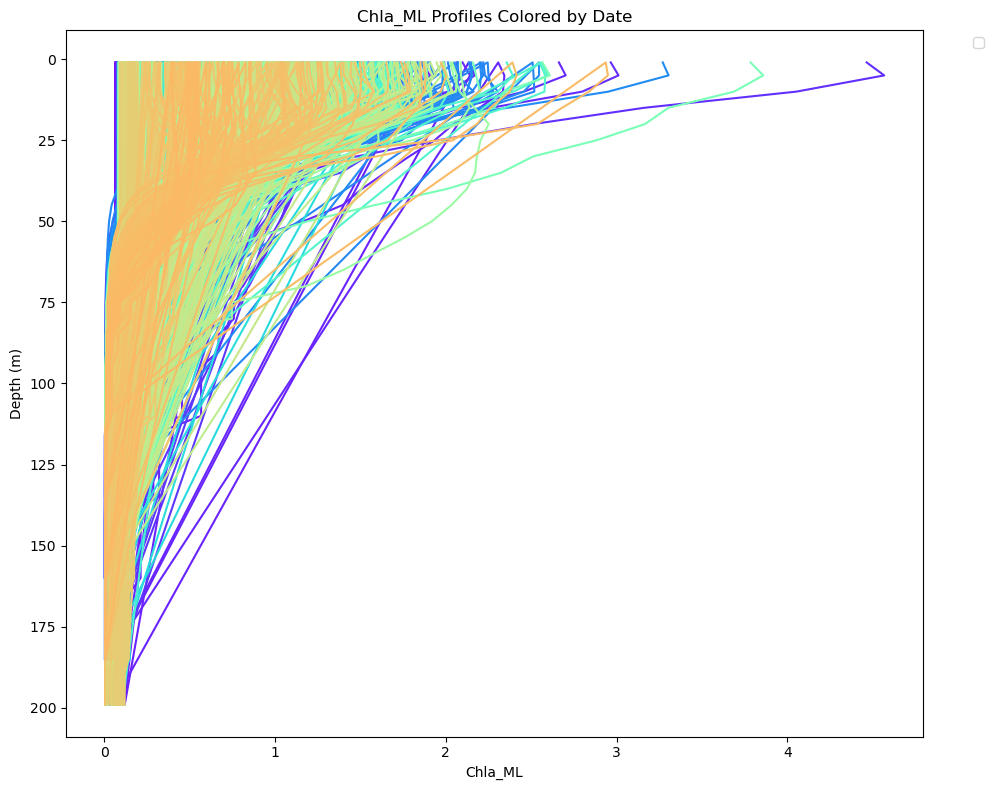

In [16]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Get unique dates and sort them
unique_dates = sorted(interpolated_df['date'].unique())

# Create a rainbow colormap
cmap = plt.get_cmap('rainbow')
norm = mcolors.Normalize(vmin=0, vmax=len(unique_dates)-1)

fig, ax = plt.subplots(figsize=(10, 8))

for i, date in enumerate(unique_dates):
    profile_data = interpolated_df[interpolated_df['date'] == date].dropna(subset=['CHLA_ML'])
    if not profile_data.empty:
        ax.plot(profile_data['CHLA_ML'], profile_data['PRES'], color=cmap(norm(i)))

ax.set_xlabel('Chla_ML')
ax.set_ylabel('Depth (m)')
ax.invert_yaxis()
ax.set_title('Chla_ML Profiles Colored by Date')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

C:\Users\petit\AppData\Local\Temp\ipykernel_44020\364959738.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


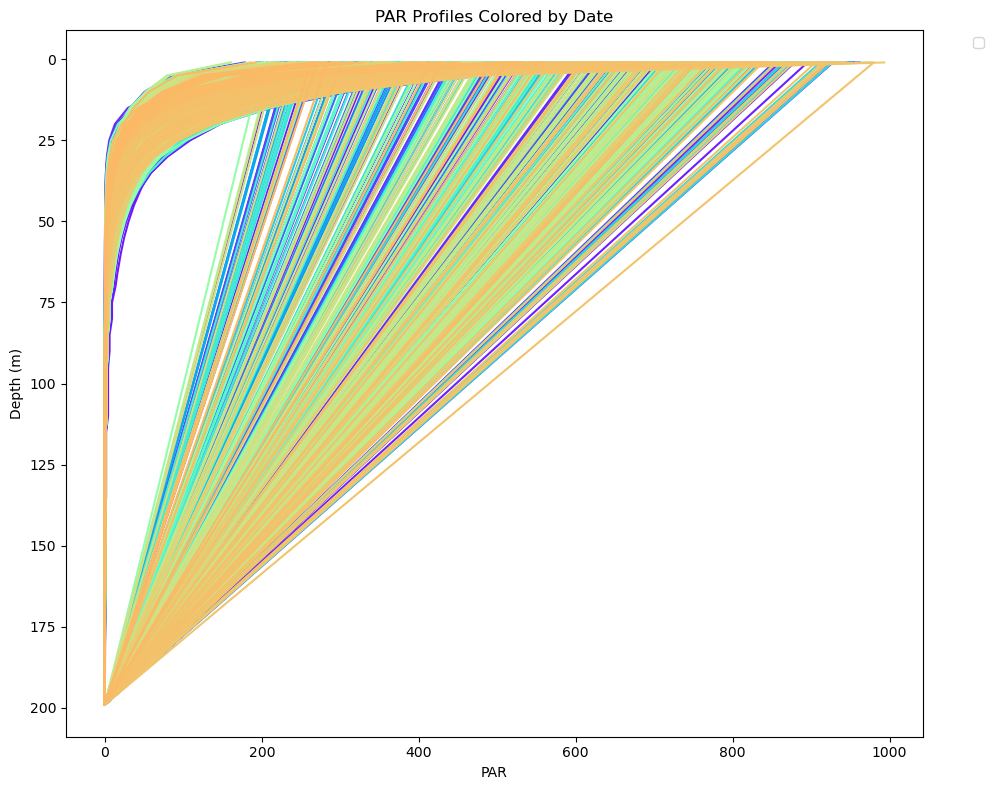

In [17]:
# Get unique dates and sort them
unique_dates = sorted(interpolated_df['date'].unique())

# Create a rainbow colormap
cmap = plt.get_cmap('rainbow')
norm = mcolors.Normalize(vmin=0, vmax=len(unique_dates)-1)

fig, ax = plt.subplots(figsize=(10, 8))

for i, date in enumerate(unique_dates):
    profile_data = interpolated_df[interpolated_df['date'] == date].dropna(subset=['PAR'])
    if not profile_data.empty:
        ax.plot(profile_data['PAR'], profile_data['PRES'], color=cmap(norm(i)))

ax.set_xlabel('PAR')
ax.set_ylabel('Depth (m)')
ax.invert_yaxis()
ax.set_title('PAR Profiles Colored by Date')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [18]:
surface_par_df = interpolated_df[interpolated_df['PRES'] == 1][['date', 'PAR', 'latitude', 'longitude']].reset_index(drop=True)
mask = surface_par_df['PAR'].notna()
surface_par_df = surface_par_df[mask]
surface_par_df

date         PAR   latitude  longitude
1    2016-03-24  504.182465  58.416000 -39.896000
2    2016-04-13  730.578979  58.500000 -39.202000
3    2016-04-23  742.701782  58.523000 -38.546000
4    2016-05-03  839.603149  58.720000 -39.087000
6    2016-05-23  773.229492  59.273000 -37.629000
...         ...         ...        ...        ...
3801 2023-08-03  838.665344  59.363087 -38.028523
3802 2023-08-13  750.136719  58.742210 -37.971777
3803 2023-08-23  664.044312  58.578557 -38.095720
3804 2023-09-02  559.594177  58.485832 -38.591845
3805 2023-09-12  550.919434  58.540050 -38.856700

[1632 rows x 4 columns]

In [19]:
import pvlib
surface_par_df = surface_par_df.reset_index(drop=True)

tz = 'UTC'
daily_par = []

for i in range(len(surface_par_df)):
    
    lat, lon = surface_par_df['latitude'][i], surface_par_df['longitude'][i]
    location = pvlib.location.Location(lat, lon, tz)

    # Full day at 1-min resolution
    date = surface_par_df['date'][i].strftime('%Y-%m-%d')
    times = pd.date_range(
        f'{date} 00:00',
        f'{date} 23:59',
        freq='1min',
        tz=tz
    )

    clearsky = location.get_clearsky(times)
    ghi = clearsky['ghi']  # W m-2
    PAR_clear = ghi *4.57 # Convert to µmol photons m2 s-1

    t_meas = pd.Timestamp(f'{date} 12:00', tz=tz)
    PAR_meas = surface_par_df['PAR'][i]  # example

    PAR_clear_meas = PAR_clear.loc[t_meas]

    scale = PAR_meas / PAR_clear_meas
    PAR_scaled = PAR_clear * scale

    # Convert µmol m-2 s-1 → mol m-2 day-1
    DLI = PAR_scaled.sum() * 60 / 1e6
    daily_par.append(DLI)

surface_par_df['daily_par'] = daily_par

In [20]:
interpolated_df = interpolated_df.merge(surface_par_df[['date', 'daily_par']], on='date', how='left')

In [21]:
interpolated_df['BBP470_ML'] = interpolated_df['BBP700_ML']/(470/400) 
interpolated_df['carbon_ML'] = 12128 * interpolated_df['BBP470_ML'] + 0.59

In [22]:
interpolated_df = interpolated_df.fillna(0)

In [23]:
def opp_befa(chl, irr, sst, dayL):
    if chl < 1.0:
        chl_tot = 38.0 * np.power(chl, 0.425)
    else:
        chl_tot = 40.2 * np.power(chl, 0.507)

    z_eu = 200.0 * np.power(chl_tot, (-0.293))

    if z_eu <= 102.0:
         z_eu = 568.2 * np.power(chl_tot, -0.746)

    if sst < -10.0:
        pb_opt = 0.0
    elif sst < -1.0:
        pb_opt = 1.13
    elif sst > 28.5:
        pb_opt = 4.0
    else:
        pb_opt = 1.2956 + 2.749e-1*sst + 6.17e-2*np.power(sst, 2) - \
            2.05e-2*np.power(sst, 3) + 2.462e-3*np.power(sst, 4) - \
            1.348e-4*np.power(sst, 5) + 3.4132e-6*np.power(sst, 6) - \
            3.27e-8*np.power(sst, 7)

    irrFunc = 0.66125 * irr / (irr + 4.1)

    npp = pb_opt * chl * dayL * irrFunc * z_eu

    return npp

def cal_dayL(lat, yDay):
    gamma = lat/180.0 * np.pi
    psi = yDay/365.0 * 2.0 * np.pi
    solarDec = (0.39637 - 22.9133*np.cos(psi) + 4.02543*np.sin(psi) - \
                0.38720*np.cos(2*psi) + 0.05200*np.sin(2*psi)) * np.pi/180.0
    r = -np.tan(gamma) * np.tan(solarDec)

    if r<=-1:
        return 24.0
    elif np.fabs(r)<1:
        return 24.0 * np.arccos(r) / np.pi
    else:
        return 0
    
def day_of_year(day, month, year=2024):
    return (datetime.date(year, month, day) - datetime.date(year, 1, 1)).days + 1

In [24]:
interpolated_df['year'] = interpolated_df['date'].dt.year
interpolated_df['month'] = interpolated_df['date'].dt.month
interpolated_df['day'] = interpolated_df['date'].dt.day

In [25]:
import datetime
dfs = []
depth_grid = np.arange(0,200)

# Iterate through each unique profile index
for i in interpolated_df['profile_id'].unique():
    # Filter for rows corresponding to the current 'JULD'
    temp_df = interpolated_df[interpolated_df['profile_id'] == i].copy()  # Use `.copy()` to avoid warnings

    temp_df = temp_df.drop_duplicates(subset=['PRES'])
    # Extract the pressure and chlorophyll values for interpolation
    pres_values = temp_df['PRES'].to_numpy()
    temp_values = temp_df['temperature'].to_numpy()

    #extract ML derived variables
    chl_ML_values = temp_df['CHLA_ML'].to_numpy()
    carbon_ML_values = temp_df['carbon_ML'].to_numpy()

    # # Apply the running mean smoothing
    # chl_smoothed = running_mean(chl_values, window_size=5)
    # carbon_smoothed = running_mean(carbon_values, window_size=5)

    # Check for valid data before interpolation (avoid NaN values)
    mask = ~np.isnan(pres_values) & ~np.isnan(chl_ML_values)
    pres_values = pres_values[mask]
    temp_values = temp_values[mask]

    chl_ML_values = chl_ML_values[mask]
    chl_ML_values[0] = chl_ML_values[1]
    carbon_ML_values = carbon_ML_values[mask]
    carbon_ML_values[0] = carbon_ML_values[1]


    irr = temp_df['daily_par'].mean()  # Mean irradiance value
    year = int(temp_df['year'].mean())
    month = int(temp_df['month'].mean())
    day = int(temp_df['day'].mean())
    lat = temp_df['latitude'].mean()
    temp_values[0] = temp_values[1]
    sst = temp_values[0:5].mean()


    #calculation of daylength
    doy = day_of_year(day, month)
    day_length = cal_dayL(lat, doy)


    size_max = len(temp_df)


    # Call the cbpm_argo function with interpolated data from ML
    [pp_z, mu_z, par_z, prcnt_z, nutTempFunc_z, IgFunc_z, mzeu] = cbpm_argo.cbpm_argo(chl_ML_values, carbon_ML_values, irr, year, month, day, lat)

    #VGPM computation from ML
    npp_vgpm = opp_befa(chl_ML_values[1], irr, sst, day_length)

    temp_df.loc[:, 'pp_ML'] = pp_z[0:size_max]
    temp_df.loc[:, 'npp_vgpm_ML'] = np.full(size_max, npp_vgpm)
    temp_df.loc[:, 'zeu'] = np.full(size_max, mzeu)
    temp_df.loc[:, 'mu'] = mu_z[0:size_max]

    # Append modified DataFrame to the list
    dfs.append(temp_df)


# Combine all DataFrames
final_df = pd.concat(dfs)

c:\Users\petit\Documents\Producitivity_estimates\Scripts\cbpm_py\cbpm_argo.py:128: RuntimeWarning: invalid value encountered in scalar divide
  chlC_z[z] = chl_z[z] / Cphyto_z[z]
c:\Users\petit\Documents\Producitivity_estimates\Scripts\cbpm_py\cbpm_argo.py:139: RuntimeWarning: invalid value encountered in scalar divide
  prcnt_z[z] = par_z[z] / (irr * 0.975)
C:\Users\petit\AppData\Local\Temp\ipykernel_44020\1915964035.py:7: RuntimeWarning: divide by zero encountered in power
  z_eu = 200.0 * np.power(chl_tot, (-0.293))
C:\Users\petit\AppData\Local\Temp\ipykernel_44020\1915964035.py:26: RuntimeWarning: invalid value encountered in scalar multiply
  npp = pb_opt * chl * dayL * irrFunc * z_eu
c:\Users\petit\Documents\Producitivity_estimates\Scripts\cbpm_py\cbpm_argo.py:128: RuntimeWarning: invalid value encountered in scalar divide
  chlC_z[z] = chl_z[z] / Cphyto_z[z]
C:\Users\petit\AppData\Local\Temp\ipykernel_44020\1915964035.py:7: RuntimeWarning: divide by zero encountered in power
  z

In [26]:
final_df

profile_id       date  PRES   latitude  longitude  CHLA_ML  \
0        1901210_166 2016-02-13     0  58.003000 -38.136000      0.0   
1        1901210_166 2016-02-13     1  58.003000 -38.136000      0.0   
2        1901210_166 2016-02-13     2  58.003000 -38.136000      0.0   
3        1901210_166 2016-02-13     3  58.003000 -38.136000      0.0   
4        1901210_166 2016-02-13     4  58.003000 -38.136000      0.0   
...              ...        ...   ...        ...        ...      ...   
1092795    7902223_9 2024-09-10   195  62.327156 -19.961777      0.0   
1092796    7902223_9 2024-09-10   196  62.327156 -19.961777      0.0   
1092797    7902223_9 2024-09-10   197  62.327156 -19.961777      0.0   
1092798    7902223_9 2024-09-10   198  62.327156 -19.961777      0.0   
1092799    7902223_9 2024-09-10   199  62.327156 -19.961777      0.0   

         BBP700_ML  PAR  temperature   salinity  daily_par  BBP470_ML  \
0              0.0  0.0     0.000000   0.000000        0.0        0.0   
1              0.0  0.0     3.948000  34.893499        0.0        0.0   
2              0.0  0.0     3.949750  34.892375        0.0        0.0   
3              0.0  0.0     3.951500  34.891250        0.0        0.0   
4              0.0  0.0     3.953250  34.890125        0.0        0.0   
...            ...  ...          ...        ...        ...        ...   
1092795        0.0  0.0     8.870595  35.272999        0.0        0.0   
1092796        0.0  0.0     8.869004  35.272749        0.0        0.0   
1092797        0.0  0.0     8.867412  35.272499        0.0        0.0   
1092798        0.0  0.0     8.865820  35.272249        0.0        0.0   
1092799        0.0  0.0     8.864228  35.271999        0.0        0.0   

         carbon_ML  year  month  day  pp_ML  npp_vgpm_ML  zeu  mu  
0              0.0  2016      2   13    NaN          NaN  NaN NaN  
1              0.0  2016      2   13    NaN          NaN  NaN NaN  
2              0.0  2016      2   13    NaN          NaN  NaN NaN  
3              0.0  2016      2   13    NaN          NaN  NaN NaN  
4              0.0  2016      2   13    NaN          NaN  NaN NaN  
...            ...   ...    ...  ...    ...          ...  ...  ..  
1092795        0.0  2024      9   10    NaN          NaN  NaN NaN  
1092796        0.0  2024      9   10    NaN          NaN  NaN NaN  
1092797        0.0  2024      9   10    NaN          NaN  NaN NaN  
1092798        0.0  2024      9   10    NaN          NaN  NaN NaN  
1092799        0.0  2024      9   10    NaN          NaN  NaN NaN  

[771600 rows x 20 columns]

In [59]:
# filter to check this profile in final_df 1901210_175
test_df = final_df[final_df['profile_id'] == '1901210_175']
test_df

profile_id       date  PRES  latitude  longitude  CHLA_ML  BBP700_ML  \
2000  1901210_175 2016-05-13     0     59.04    -38.556      0.0        0.0   
2001  1901210_175 2016-05-13     1     59.04    -38.556      0.0        0.0   
2002  1901210_175 2016-05-13     2     59.04    -38.556      0.0        0.0   
2003  1901210_175 2016-05-13     3     59.04    -38.556      0.0        0.0   
2004  1901210_175 2016-05-13     4     59.04    -38.556      0.0        0.0   
...           ...        ...   ...       ...        ...      ...        ...   
2195  1901210_175 2016-05-13   195     59.04    -38.556      0.0        0.0   
2196  1901210_175 2016-05-13   196     59.04    -38.556      0.0        0.0   
2197  1901210_175 2016-05-13   197     59.04    -38.556      0.0        0.0   
2198  1901210_175 2016-05-13   198     59.04    -38.556      0.0        0.0   
2199  1901210_175 2016-05-13   199     59.04    -38.556      0.0        0.0   

      PAR  temperature   salinity  daily_par  BBP470_ML  carbon_ML  year  \
2000  0.0     0.000000   0.000000  26.734345        0.0        0.0  2016   
2001  0.0     4.578000  34.877998  26.734345        0.0        0.0  2016   
2002  0.0     4.578125  34.878499  26.734345        0.0        0.0  2016   
2003  0.0     4.578250  34.879000  26.734345        0.0        0.0  2016   
2004  0.0     4.578375  34.879500  26.734345        0.0        0.0  2016   
...   ...          ...        ...        ...        ...        ...   ...   
2195  0.0     3.648000  34.886002  26.734345        0.0        0.0  2016   
2196  0.0     3.647100  34.886002  26.734345        0.0        0.0  2016   
2197  0.0     3.646200  34.886002  26.734345        0.0        0.0  2016   
2198  0.0     3.645300  34.886002  26.734345        0.0        0.0  2016   
2199  0.0     3.644400  34.886002  26.734345        0.0        0.0  2016   

      month  day  pp_ML  npp_vgpm_ML    zeu  mu  
2000      5   13    NaN          NaN  199.0 NaN  
2001      5   13    NaN          NaN  199.0 NaN  
2002      5   13    NaN          NaN  199.0 NaN  
2003      5   13    NaN          NaN  199.0 NaN  
2004      5   13    NaN          NaN  199.0 NaN  
...     ...  ...    ...          ...    ...  ..  
2195      5   13    NaN          NaN  199.0 NaN  
2196      5   13    NaN          NaN  199.0 NaN  
2197      5   13    NaN          NaN  199.0 NaN  
2198      5   13    NaN          NaN  199.0 NaN  
2199      5   13    NaN          NaN  199.0 NaN  

[200 rows x 20 columns]

C:\Users\petit\AppData\Local\Temp\ipykernel_44020\2326314394.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_df = final_df.groupby('profile_id').apply(filter_profiles).reset_index(drop=True)


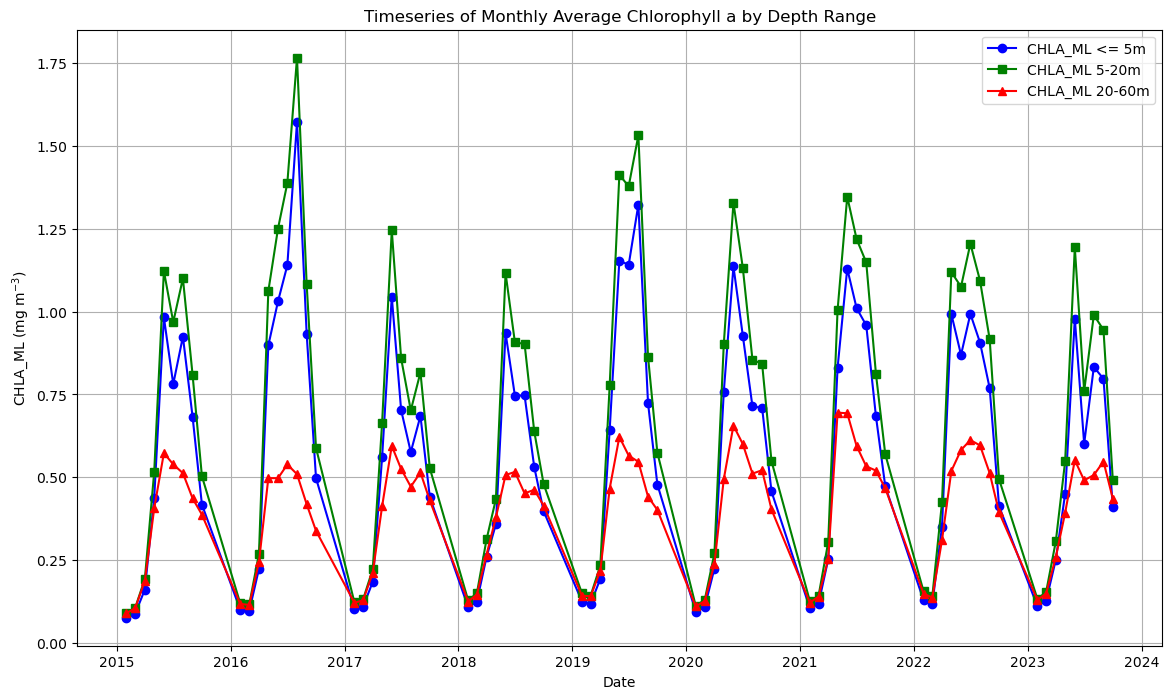

In [67]:
# Filter out profiles where the mean CHLA_ML between PRES 0 and 5 is 0
def filter_profiles(group):
    mean_chla = group[(group['PRES'] >= 0) & (group['PRES'] <= 5)]['CHLA_ML'].mean()
    if mean_chla == 0:
        return pd.DataFrame()  # Return empty DataFrame to exclude the profile
    else:
        return group

filtered_df = final_df.groupby('profile_id').apply(filter_profiles).reset_index(drop=True)

# Extract CHLA_ML for different depth ranges
surface_chla = filtered_df[filtered_df['PRES'] <= 5][['date', 'CHLA_ML']].copy()
mid_chla = filtered_df[(filtered_df['PRES'] > 5) & (filtered_df['PRES'] <= 20)][['date', 'CHLA_ML']].copy()
deep_chla = filtered_df[(filtered_df['PRES'] > 20) & (filtered_df['PRES'] <= 60)][['date', 'CHLA_ML']].copy()

# Add year and month for grouping
for df in [surface_chla, mid_chla, deep_chla]:
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month

# Compute monthly averages for each depth range
monthly_avg_surface = surface_chla.groupby(['year', 'month'])['CHLA_ML'].mean().reset_index()
monthly_avg_mid = mid_chla.groupby(['year', 'month'])['CHLA_ML'].mean().reset_index()
monthly_avg_deep = deep_chla.groupby(['year', 'month'])['CHLA_ML'].mean().reset_index()

# Create date columns for plotting
for df in [monthly_avg_surface, monthly_avg_mid, monthly_avg_deep]:
    df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

# Plot the timeseries with different colors for each depth range
plt.figure(figsize=(14, 8))
plt.plot(monthly_avg_surface['date'], monthly_avg_surface['CHLA_ML'], marker='o', linestyle='-', color='blue', label='CHLA_ML <= 5m')
plt.plot(monthly_avg_mid['date'], monthly_avg_mid['CHLA_ML'], marker='s', linestyle='-', color='green', label='CHLA_ML 5-20m')
plt.plot(monthly_avg_deep['date'], monthly_avg_deep['CHLA_ML'], marker='^', linestyle='-', color='red', label='CHLA_ML 20-60m')
plt.xlabel('Date')
plt.ylabel('CHLA_ML (mg m$^{-3}$)')
plt.title('Timeseries of Monthly Average Chlorophyll a by Depth Range')
plt.legend()
plt.grid(True)
plt.show()

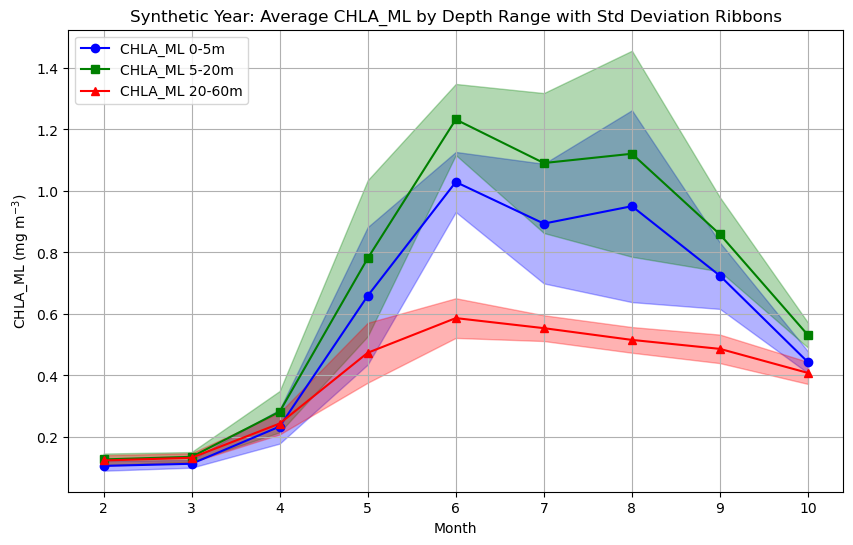

In [72]:
# Compute monthly averages for CHLA_ML in each depth range
monthly_avg_surface_chla = surface_chla.groupby(['year', 'month'])['CHLA_ML'].mean().reset_index()
monthly_avg_mid_chla = mid_chla.groupby(['year', 'month'])['CHLA_ML'].mean().reset_index()
monthly_avg_deep_chla = deep_chla.groupby(['year', 'month'])['CHLA_ML'].mean().reset_index()

# Create synthetic year by averaging across years for each month
synthetic_year_surface_chla = monthly_avg_surface_chla.groupby('month').agg({'CHLA_ML': ['mean', 'std']}).reset_index()
synthetic_year_surface_chla.columns = ['month', 'chla_mean', 'chla_std']

synthetic_year_mid_chla = monthly_avg_mid_chla.groupby('month').agg({'CHLA_ML': ['mean', 'std']}).reset_index()
synthetic_year_mid_chla.columns = ['month', 'chla_mean', 'chla_std']

synthetic_year_deep_chla = monthly_avg_deep_chla.groupby('month').agg({'CHLA_ML': ['mean', 'std']}).reset_index()
synthetic_year_deep_chla.columns = ['month', 'chla_mean', 'chla_std']

# Plot the synthetic year for CHLA_ML in different depth ranges
plt.figure(figsize=(10, 6))

# Surface (0-5m)
plt.plot(synthetic_year_surface_chla['month'], synthetic_year_surface_chla['chla_mean'], label='CHLA_ML 0-5m', marker='o', color='blue')
plt.fill_between(synthetic_year_surface_chla['month'], 
                 synthetic_year_surface_chla['chla_mean'] - synthetic_year_surface_chla['chla_std'], 
                 synthetic_year_surface_chla['chla_mean'] + synthetic_year_surface_chla['chla_std'], 
                 alpha=0.3, color='blue')

# Mid (5-20m)
plt.plot(synthetic_year_mid_chla['month'], synthetic_year_mid_chla['chla_mean'], label='CHLA_ML 5-20m', marker='s', color='green')
plt.fill_between(synthetic_year_mid_chla['month'], 
                 synthetic_year_mid_chla['chla_mean'] - synthetic_year_mid_chla['chla_std'], 
                 synthetic_year_mid_chla['chla_mean'] + synthetic_year_mid_chla['chla_std'], 
                 alpha=0.3, color='green')

# Deep (20-60m)
plt.plot(synthetic_year_deep_chla['month'], synthetic_year_deep_chla['chla_mean'], label='CHLA_ML 20-60m', marker='^', color='red')
plt.fill_between(synthetic_year_deep_chla['month'], 
                 synthetic_year_deep_chla['chla_mean'] - synthetic_year_deep_chla['chla_std'], 
                 synthetic_year_deep_chla['chla_mean'] + synthetic_year_deep_chla['chla_std'], 
                 alpha=0.3, color='red')

plt.xlabel('Month')
plt.ylabel('CHLA_ML (mg m$^{-3}$)')
plt.title('Synthetic Year: Average CHLA_ML by Depth Range with Std Deviation Ribbons')
plt.legend()
plt.grid(True)
plt.show()

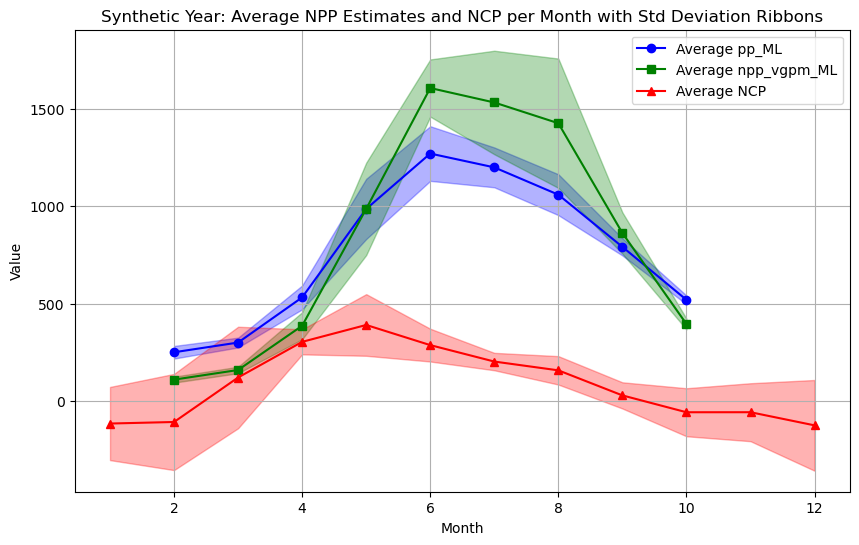

In [71]:
import matplotlib.pyplot as plt

# Assuming synthetic_year and synthetic_year_ncp are already defined from previous cells
# Plot the synthetic year for pp_ML, npp_vgpm_ML, and NCP in a single panel with different colors
plt.figure(figsize=(10, 6))

# pp_ML
plt.plot(synthetic_year['month'], synthetic_year['pp_ML_mean'], label='Average pp_ML', marker='o', color='blue')
plt.fill_between(synthetic_year['month'], 
                 synthetic_year['pp_ML_mean'] - synthetic_year['pp_ML_std'], 
                 synthetic_year['pp_ML_mean'] + synthetic_year['pp_ML_std'], 
                 alpha=0.3, color='blue')

# npp_vgpm_ML
plt.plot(synthetic_year['month'], synthetic_year['npp_vgpm_ML_mean'], label='Average npp_vgpm_ML', marker='s', color='green')
plt.fill_between(synthetic_year['month'], 
                 synthetic_year['npp_vgpm_ML_mean'] - synthetic_year['npp_vgpm_ML_std'], 
                 synthetic_year['npp_vgpm_ML_mean'] + synthetic_year['npp_vgpm_ML_std'], 
                 alpha=0.3, color='green')

# NCP
plt.plot(synthetic_year_ncp['month'], synthetic_year_ncp['NCP_mean']*12, label='Average NCP', marker='^', color='red')
plt.fill_between(synthetic_year_ncp['month'], 
                 synthetic_year_ncp['NCP_mean']*12 - synthetic_year_ncp['NCP_std']*12, 
                 synthetic_year_ncp['NCP_mean']*12 + synthetic_year_ncp['NCP_std']*12, 
                 alpha=0.3, color='red')

plt.xlabel('Month')
plt.ylabel('Value')
plt.title('Synthetic Year: Average NPP Estimates and NCP per Month with Std Deviation Ribbons')
plt.legend()
plt.grid(True)
plt.show()


In [73]:
# Create a new dataframe with one row per profile_id
# Integrate pp and pp_ML over depth (sum, assuming 1m depth bins)
# Keep average of npp_vgpm and npp_vgpm_ML (which are constant per profile)

grouped = filtered_df.groupby('profile_id')

profile_summary_df = grouped.agg({
    'date': 'first',
    'latitude': 'first',
    'longitude': 'first',
    'pp_ML': 'sum',
    'npp_vgpm_ML': 'mean'
})

profile_summary_df

date   latitude  longitude        pp_ML  npp_vgpm_ML
profile_id                                                            
1901210_170 2016-03-24  58.416000 -39.896000   341.344588   135.039664
1901210_172 2016-04-13  58.500000 -39.202000   502.134434   246.834853
1901210_173 2016-04-23  58.523000 -38.546000   602.173028   372.761716
1901210_174 2016-05-03  58.720000 -39.087000   846.783927   626.234151
1901210_176 2016-05-23  59.273000 -37.629000  1365.417484  1293.130594
...                ...        ...        ...          ...          ...
7901037_5   2023-08-03  59.363087 -38.028523  1026.375739   854.477537
7901037_6   2023-08-13  58.742210 -37.971777  1108.887634  1212.654377
7901037_7   2023-08-23  58.578557 -38.095720  1042.507315  1194.126766
7901037_8   2023-09-02  58.485832 -38.591845  1020.251045  1366.511968
7901037_9   2023-09-12  58.540050 -38.856700   884.973274   797.906491

[1632 rows x 5 columns]

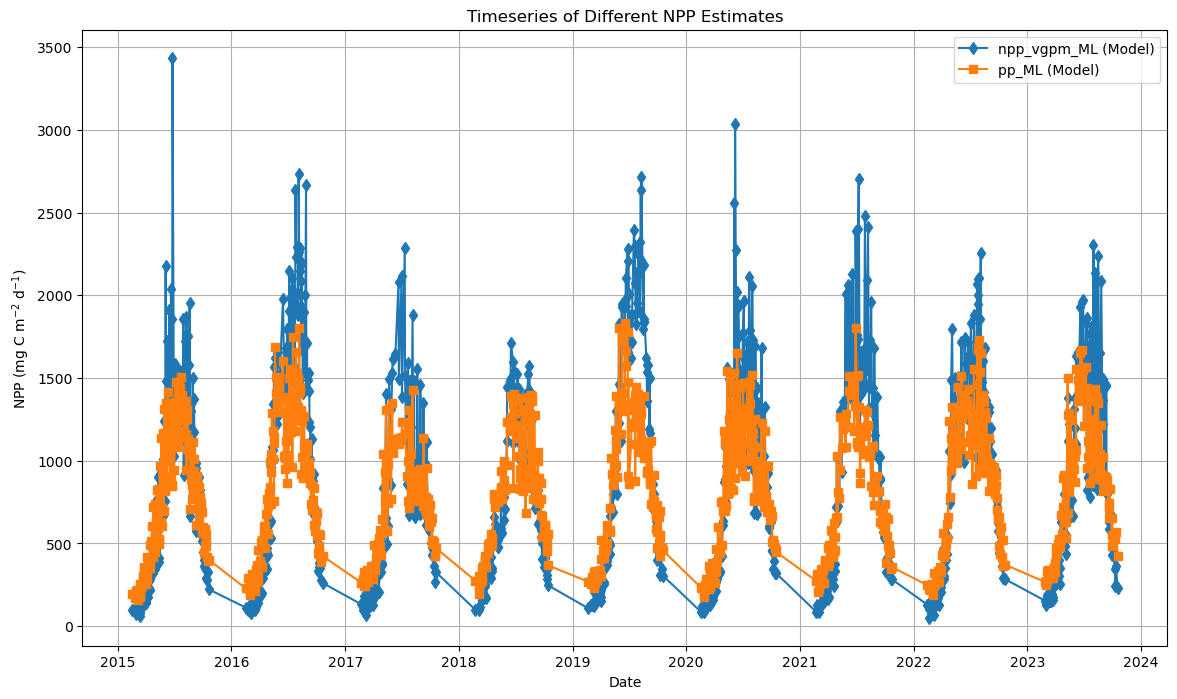

In [74]:
# Aggregate by date
daily_mean = profile_summary_df.groupby('date').mean().reset_index()

daily_mean = daily_mean[daily_mean['date'] < '2024-01-01']

plt.figure(figsize=(14, 8))
plt.plot(daily_mean['date'], daily_mean['npp_vgpm_ML'], label='npp_vgpm_ML (Model)', marker='d')
plt.plot(daily_mean['date'], daily_mean['pp_ML'], label='pp_ML (Model)', marker='s')


plt.xlabel('Date')
plt.ylabel('NPP (mg C m$^{-2}$ d$^{-1}$)')
plt.title('Timeseries of Different NPP Estimates')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\petit\AppData\Local\Temp\ipykernel_44020\3151684369.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')


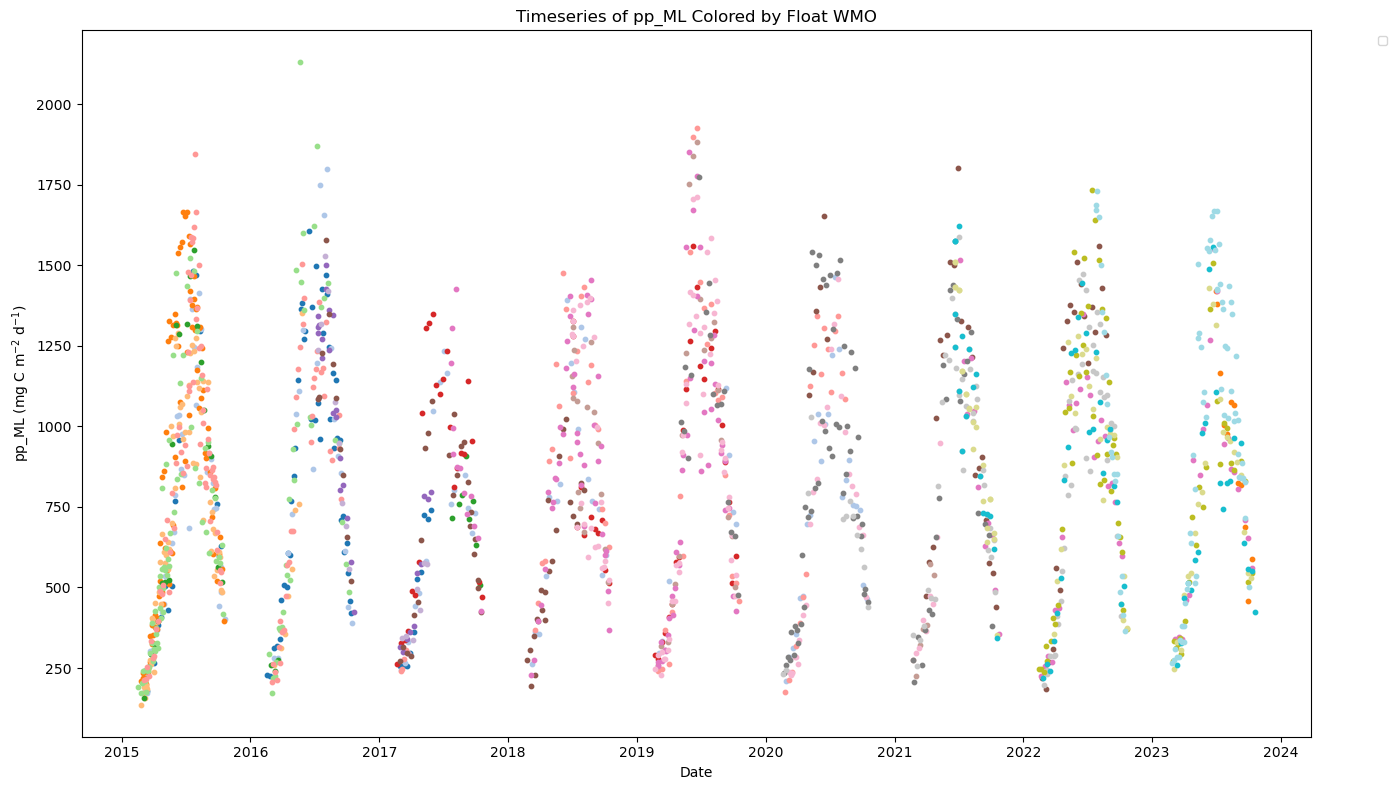

In [75]:
# Extract float_wmo from profile_id
profile_summary_df['float_wmo'] = profile_summary_df.index.str.split('_').str[0]

# Get unique float_wmo for coloring
unique_wmos = sorted(profile_summary_df['float_wmo'].unique())

# Create a colormap
cmap = plt.get_cmap('tab20')  # Use tab20 for distinct colors
norm = mcolors.Normalize(vmin=0, vmax=len(unique_wmos)-1)

fig, ax = plt.subplots(figsize=(14, 8))

for i, wmo in enumerate(unique_wmos):
    wmo_data = profile_summary_df[profile_summary_df['float_wmo'] == wmo]
    ax.scatter(wmo_data['date'], wmo_data['pp_ML'], color=cmap(norm(i)), s=10)

ax.set_xlabel('Date')
ax.set_ylabel('pp_ML (mg C m$^{-2}$ d$^{-1}$)')
ax.set_title('Timeseries of pp_ML Colored by Float WMO')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

In [30]:
profile_summary_df

date   latitude  longitude       pp_ML  npp_vgpm_ML  \
profile_id                                                              
1901210_166 2016-02-13  58.003000 -38.136000    0.000000          NaN   
1901210_170 2016-03-24  58.416000 -39.896000  341.344588   135.039664   
1901210_172 2016-04-13  58.500000 -39.202000  502.134434   246.834853   
1901210_173 2016-04-23  58.523000 -38.546000  602.173028   372.761716   
1901210_174 2016-05-03  58.720000 -39.087000  846.783927   626.234151   
...                ...        ...        ...         ...          ...   
7902223_52  2025-10-27  61.084361 -30.606907    0.000000          NaN   
7902223_6   2024-09-07  62.330171 -19.602902    0.000000          NaN   
7902223_7   2024-09-08  62.354183 -19.749048    0.000000          NaN   
7902223_8   2024-09-09  62.351090 -19.861938    0.000000          NaN   
7902223_9   2024-09-10  62.327156 -19.961777    0.000000          NaN   

            float_wmo  
profile_id             
1901210_166   1901210  
1901210_170   1901210  
1901210_172   1901210  
1901210_173   1901210  
1901210_174   1901210  
...               ...  
7902223_52    7902223  
7902223_6     7902223  
7902223_7     7902223  
7902223_8     7902223  
7902223_9     7902223  

[3858 rows x 6 columns]

In [60]:
from scipy.interpolate import interp1d

import statsmodels.api as sm

def interpolate_zeros_loess(group):
    group = group.sort_values('date')
    x = (group['date'] - group['date'].min()).dt.days
    for col in ['pp_ML', 'npp_vgpm_ML']:
        y = group[col].copy()
        mask_zero = y == 0
        mask_valid = ~y.isna() & (y != 0)
        if mask_valid.sum() > 1:
            lowess = sm.nonparametric.lowess(y[mask_valid], x[mask_valid], frac=0.3)
            f = interp1d(x[mask_valid], lowess[:, 1], kind='linear', fill_value='extrapolate')
            y[mask_zero] = f(x[mask_zero])
            group[col] = y
    return group

profile_summary_df = profile_summary_df.groupby('float_wmo').apply(interpolate_zeros_loess).reset_index(drop=True)

C:\Users\petit\AppData\Local\Temp\ipykernel_44020\3618178794.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  profile_summary_df = profile_summary_df.groupby('float_wmo').apply(interpolate_zeros_loess).reset_index(drop=True)


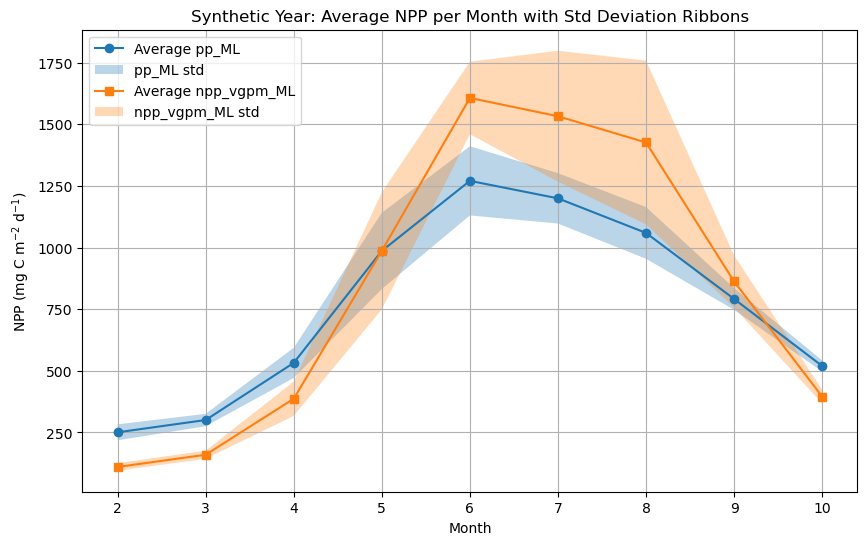

In [31]:
# Filter out rows where pp_ML is 0
filtered_df = profile_summary_df[profile_summary_df['pp_ML'] != 0].copy()

# Extract year and month from date
filtered_df['year'] = filtered_df['date'].dt.year
filtered_df['month'] = filtered_df['date'].dt.month

# Group by year and month, then average pp_ML and npp_vgpm_ML
monthly_avg = filtered_df.groupby(['year', 'month']).agg({
    'pp_ML': 'mean',
    'npp_vgpm_ML': 'mean'
}).reset_index()

# Now, to build a synthetic year, average across years for each month and compute std
synthetic_year = monthly_avg.groupby('month').agg({
    'pp_ML': ['mean', 'std'],
    'npp_vgpm_ML': ['mean', 'std']
}).reset_index()
synthetic_year.columns = ['month', 'pp_ML_mean', 'pp_ML_std', 'npp_vgpm_ML_mean', 'npp_vgpm_ML_std']

# Plot the synthetic year averages with std ribbons
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(synthetic_year['month'], synthetic_year['pp_ML_mean'], label='Average pp_ML', marker='o')
plt.fill_between(synthetic_year['month'], 
                 synthetic_year['pp_ML_mean'] - synthetic_year['pp_ML_std'], 
                 synthetic_year['pp_ML_mean'] + synthetic_year['pp_ML_std'], 
                 alpha=0.3, label='pp_ML std')
plt.plot(synthetic_year['month'], synthetic_year['npp_vgpm_ML_mean'], label='Average npp_vgpm_ML', marker='s')
plt.fill_between(synthetic_year['month'], 
                 synthetic_year['npp_vgpm_ML_mean'] - synthetic_year['npp_vgpm_ML_std'], 
                 synthetic_year['npp_vgpm_ML_mean'] + synthetic_year['npp_vgpm_ML_std'], 
                 alpha=0.3, label='npp_vgpm_ML std')
plt.xlabel('Month')
plt.ylabel('NPP (mg C m$^{-2}$ d$^{-1}$)')
plt.title('Synthetic Year: Average NPP per Month with Std Deviation Ribbons')
plt.legend()
plt.grid(True)
plt.show()

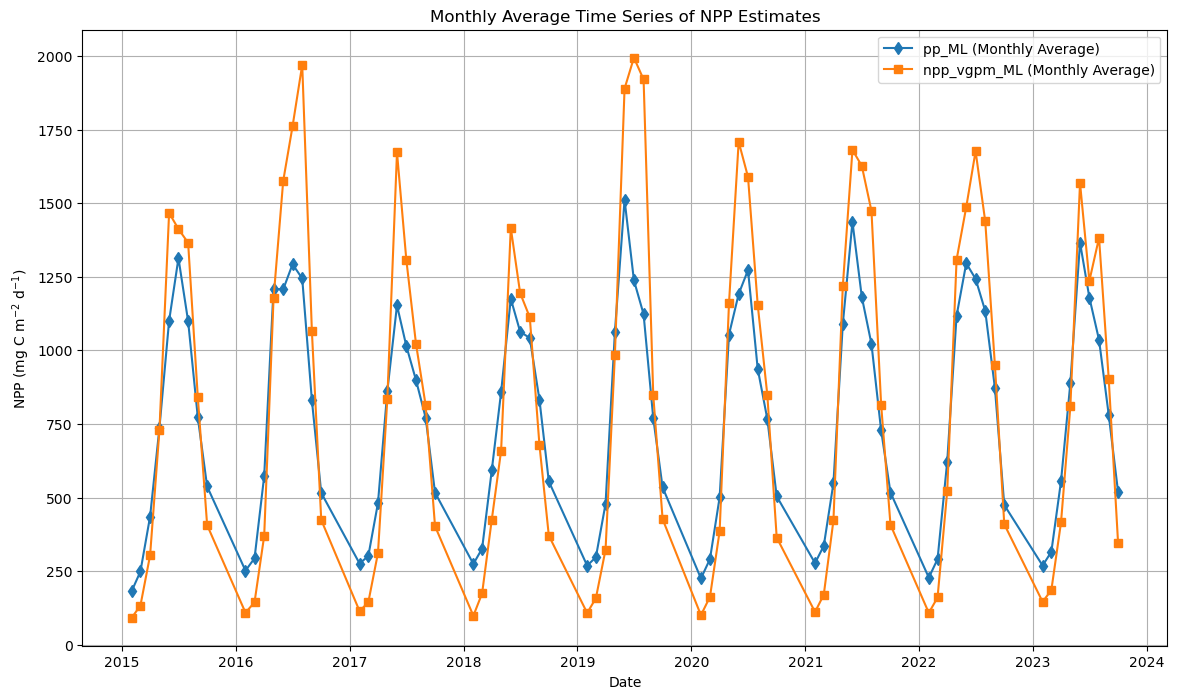

In [32]:


# Create a date column for plotting
monthly_avg['date'] = pd.to_datetime(monthly_avg[['year', 'month']].assign(day=1))

plt.figure(figsize=(14, 8))
plt.plot(monthly_avg['date'], monthly_avg['pp_ML'], label='pp_ML (Monthly Average)', marker='d')
plt.plot(monthly_avg['date'], monthly_avg['npp_vgpm_ML'], label='npp_vgpm_ML (Monthly Average)', marker='s')

plt.xlabel('Date')
plt.ylabel('NPP (mg C m$^{-2}$ d$^{-1}$)')
plt.title('Monthly Average Time Series of NPP Estimates')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
ncp = pd.read_csv("../Data/Processed/ncp_results.csv")

In [34]:
ncp

date_10day         mld   zeu  int_N_mmol_m2  next_int_N_mmol_m2  \
0    2015-01-18  512.642926  40.0    8000.524618         8263.077880   
1    2015-01-23  528.961490  40.0    7946.497971         8140.195033   
2    2015-01-28  540.126348  40.0    8351.244121         8463.459701   
3    2015-02-02  547.268503  40.0    8427.278120         8493.578057   
4    2015-02-07  551.567213  40.0    8491.033699         8602.959160   
..          ...         ...   ...            ...                 ...   
773  2025-09-27   49.479849  40.0     327.329457          353.783457   
774  2025-10-02   52.688848  40.0     355.019393          386.993434   
775  2025-10-07   56.164928  40.0     428.941041          465.517907   
776  2025-10-12   60.223117  40.0     429.926099          462.903534   
777  2025-10-17   64.175413  40.0     506.873012          560.336606   

     mld_concentration  sub_mld_concentration  int_N_smooth  \
0            18.035261              18.049265   7818.047356   
1            17.615602              18.036561   8099.422237   
2            17.600021              17.638493   8241.673404   
3            18.073545              18.374166   8423.185313   
4            17.655290              17.572961   8489.899061   
..                 ...                    ...           ...   
773           7.170804              13.438242    309.074152   
774           7.490160              13.211769    370.429964   
775           8.405528              13.657423    404.628845   
776           8.031068              12.307523    455.246717   
777           9.301008              14.156799    512.171978   

     next_int_N_smooth  dt  ...       diff  nitrate_consumption  \
0          8061.319398   5  ...   0.234375            83.089393   
1          8288.910871   5  ...   6.869456           -38.102839   
2          8365.744264   5  ...   0.429540            47.237468   
3          8519.998973   5  ...   2.147083           -57.441049   
4          8635.801641   5  ...  -0.353910            30.099912   
..                 ...  ..  ...        ...                  ...   
773         335.024171   5  ...  17.064367           -18.893789   
774         402.098266   5  ...  18.360639           -35.405793   
775         438.471625   5  ...  18.256007            -2.530578   
776         496.252682   5  ...  17.354661           -16.775092   
777         553.784337   5  ...  19.191527           -15.919296   

     c_consumption         NCP  ncp_smooth     ncp_sd  ncp_signif  \
0       110.093445  110.327820         NaN        NaN         NaN   
1       -50.486262  -43.616806         NaN        NaN         NaN   
2        62.589644   63.019185   17.332577  68.340558         NaN   
3       -76.109391  -73.962308    0.004998  51.035126         NaN   
4        39.882383   39.528474   -2.350717  53.707595   -2.456094   
..             ...         ...         ...        ...         ...   
773     -25.034271   -7.969904    0.858856  21.343028         NaN   
774     -46.912675  -28.552036   -5.115377  13.974818         NaN   
775      -3.353016   14.902991         NaN        NaN         NaN   
776     -22.226997   -4.872336         NaN        NaN         NaN   
777     -21.093067   -1.901540         NaN        NaN         NaN   

     integration  datenum  loess_ncp  
0            mld    16453  20.959572  
1            mld    16458  20.715121  
2            mld    16463  20.472244  
3            mld    16468  20.230928  
4            mld    16473  19.991158  
..           ...      ...        ...  
773          mld    20358   6.226898  
774          mld    20363   6.181292  
775          mld    20368   6.135602  
776          mld    20373   6.089812  
777          mld    20378   6.043910  

[778 rows x 23 columns]

In [35]:
# Convert date_10day to datetime and extract month and year
ncp['date_10day'] = pd.to_datetime(ncp['date_10day'])
ncp['year'] = ncp['date_10day'].dt.year
ncp['month'] = ncp['date_10day'].dt.month

# Filter out rows where NCP is NaN or invalid
filtered_ncp = ncp.dropna(subset=['NCP'])

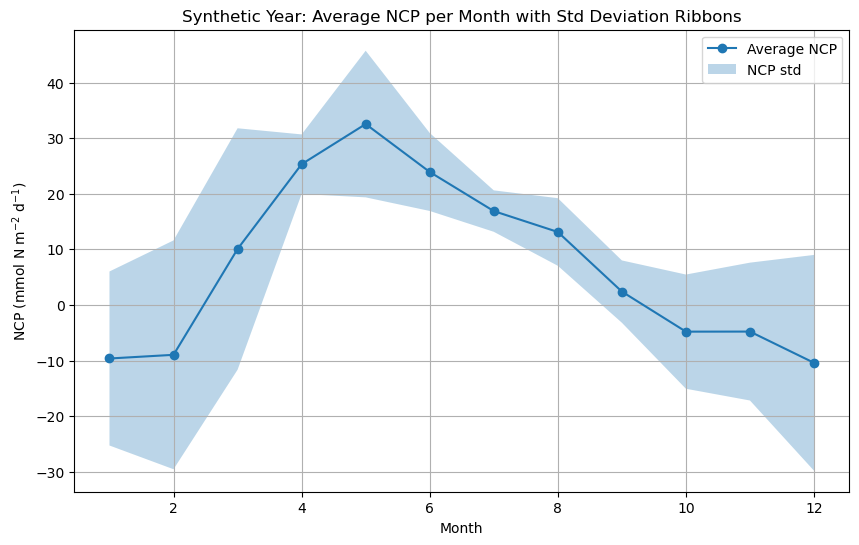

In [36]:
# Group by year and month, then average NCP
monthly_avg_ncp = filtered_ncp.groupby(['year', 'month']).agg({'ncp_smooth': ['mean', 'std']}).reset_index()
monthly_avg_ncp.columns = ['year', 'month', 'NCP_mean', 'NCP_std']

# Now, to build a synthetic year, average across years for each month and compute std
synthetic_year_ncp = monthly_avg_ncp.groupby('month').agg({
    'NCP_mean': ['mean', 'std']
}).reset_index()
synthetic_year_ncp.columns = ['month', 'NCP_mean', 'NCP_std']

# Plot the synthetic year averages with std ribbons
plt.figure(figsize=(10, 6))
plt.plot(synthetic_year_ncp['month'], synthetic_year_ncp['NCP_mean'], label='Average NCP', marker='o')
plt.fill_between(synthetic_year_ncp['month'], 
                 synthetic_year_ncp['NCP_mean'] - synthetic_year_ncp['NCP_std'], 
                 synthetic_year_ncp['NCP_mean'] + synthetic_year_ncp['NCP_std'], 
                 alpha=0.3, label='NCP std')
plt.xlabel('Month')
plt.ylabel('NCP (mmol N m$^{-2}$ d$^{-1}$)')
plt.title('Synthetic Year: Average NCP per Month with Std Deviation Ribbons')
plt.legend()
plt.grid(True)
plt.show()

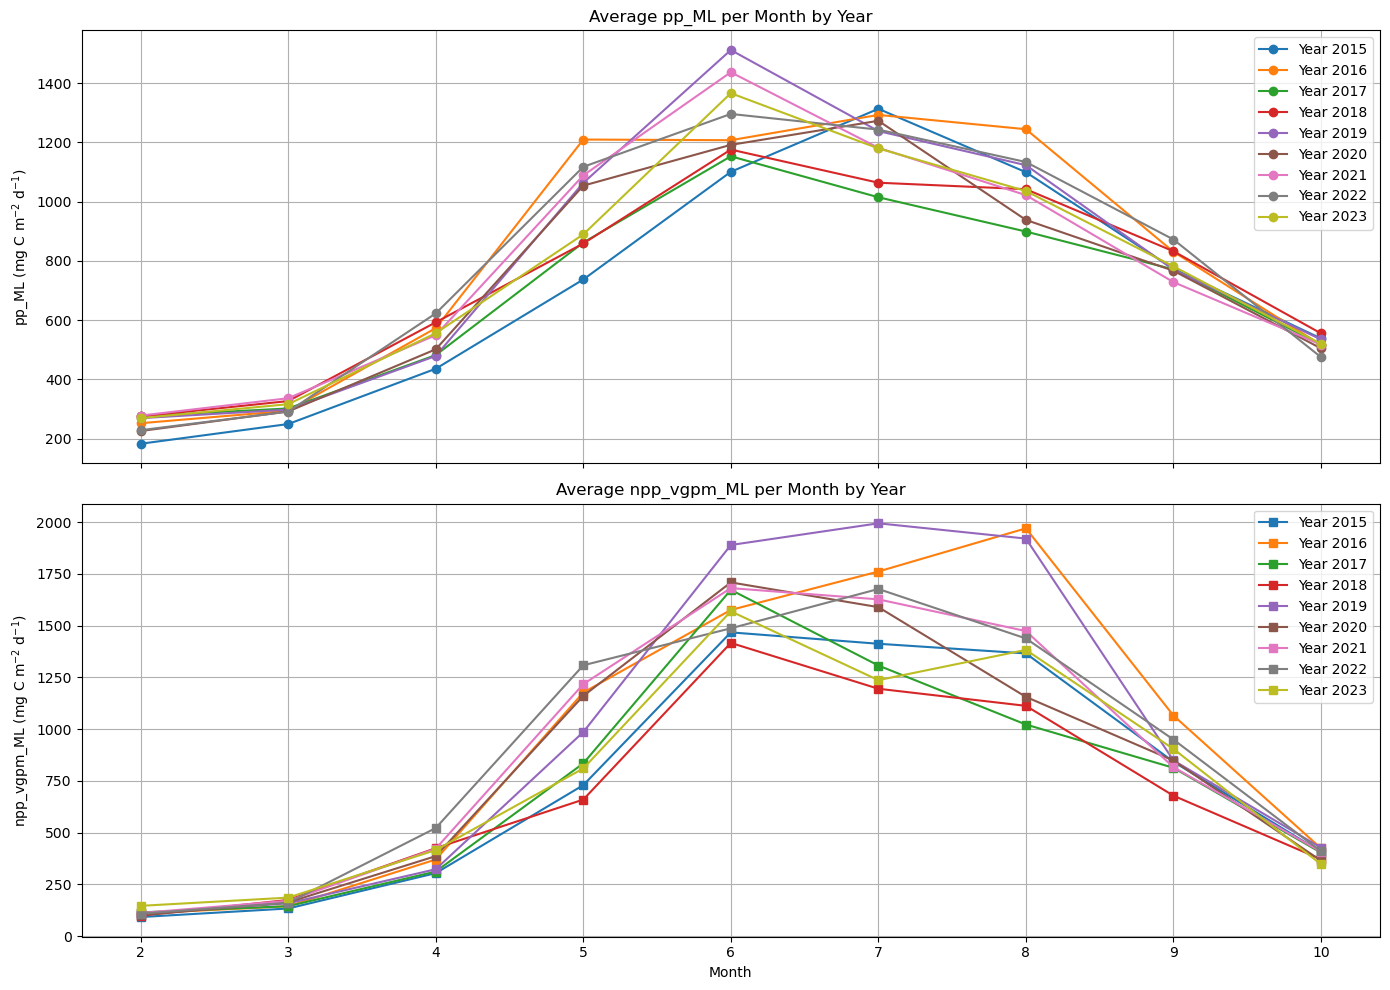

In [37]:
import matplotlib.pyplot as plt

# Assuming monthly_avg is already defined from previous cells
# Plot average pp_ML and npp_vgpm_ML per month for each year
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Group by year for plotting
for year in monthly_avg['year'].unique():
    year_data = monthly_avg[monthly_avg['year'] == year]
    axes[0].plot(year_data['month'], year_data['pp_ML'], marker='o', label=f'Year {year}')
    axes[1].plot(year_data['month'], year_data['npp_vgpm_ML'], marker='s', label=f'Year {year}')

axes[0].set_ylabel('pp_ML (mg C m$^{-2}$ d$^{-1}$)')
axes[0].set_title('Average pp_ML per Month by Year')
axes[0].legend()
axes[0].grid(True)

axes[1].set_xlabel('Month')
axes[1].set_ylabel('npp_vgpm_ML (mg C m$^{-2}$ d$^{-1}$)')
axes[1].set_title('Average npp_vgpm_ML per Month by Year')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

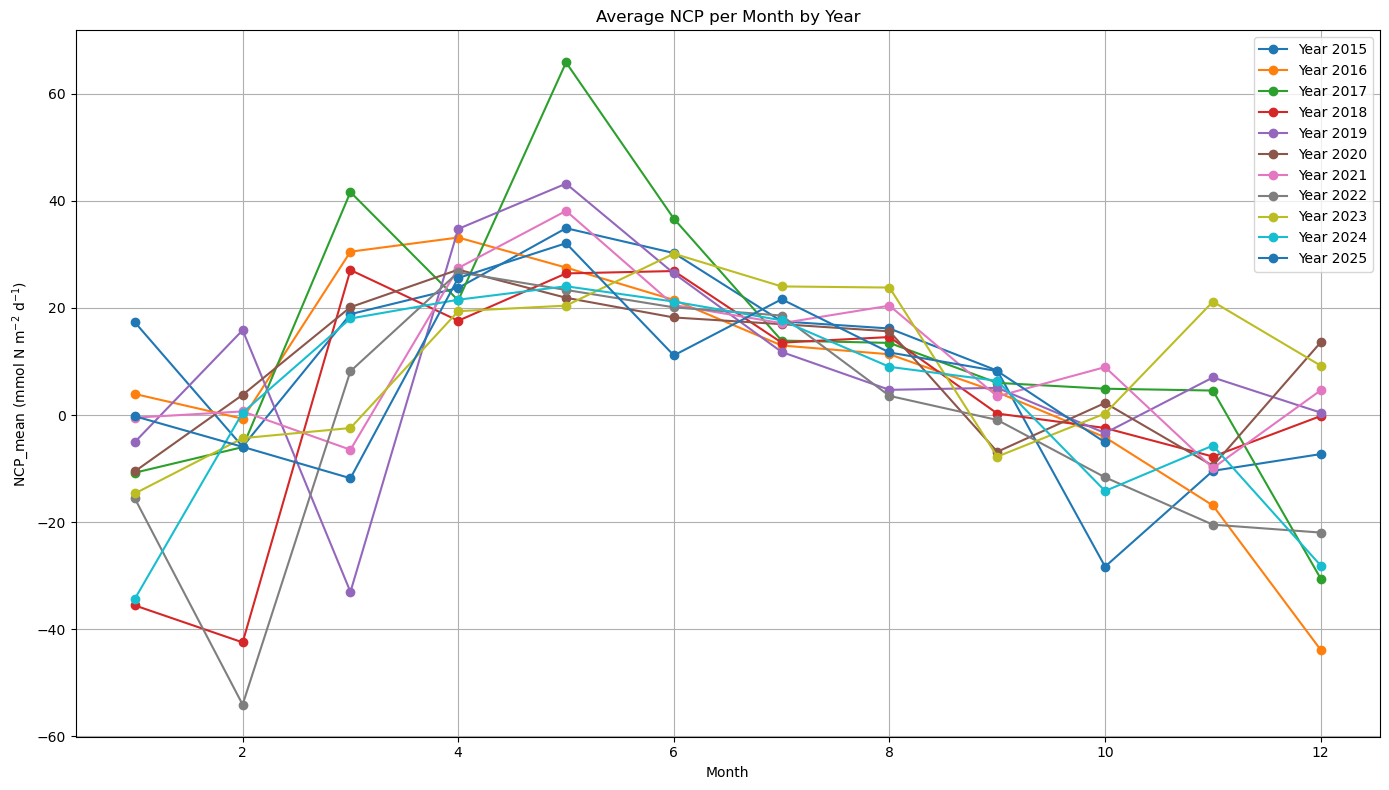

In [38]:
import matplotlib.pyplot as plt

# Plot average NCP_mean per month for each year
fig, ax = plt.subplots(figsize=(14, 8))

for year in monthly_avg_ncp['year'].unique():
    year_data = monthly_avg_ncp[monthly_avg_ncp['year'] == year]
    ax.plot(year_data['month'], year_data['NCP_mean'], marker='o', label=f'Year {year}')

ax.set_xlabel('Month')
ax.set_ylabel('NCP_mean (mmol N m$^{-2}$ d$^{-1}$)')
ax.set_title('Average NCP per Month by Year')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

In [39]:
# Merge monthly_avg and monthly_avg_ncp on year and month
monthly_time_series = pd.merge(monthly_avg, monthly_avg_ncp, on=['year', 'month'], how='outer')

# Sort by year and month
monthly_time_series = monthly_time_series.sort_values(['year', 'month']).reset_index(drop=True)

# Display the table
monthly_time_series

year  month       pp_ML  npp_vgpm_ML       date   NCP_mean   NCP_std
0    2015      1         NaN          NaN        NaT  17.332577       NaN
1    2015      2  182.415939    91.923652 2015-02-01  -5.910761  6.374722
2    2015      3  248.935928   133.182659 2015-03-01  18.845551  7.237367
3    2015      4  435.562855   303.930486 2015-04-01  23.746027  4.208637
4    2015      5  736.939324   729.071879 2015-05-01  34.903397  5.685414
..    ...    ...         ...          ...        ...        ...       ...
125  2025      6         NaN          NaN        NaT  11.138824  2.844601
126  2025      7         NaN          NaN        NaT  21.628635  4.811473
127  2025      8         NaN          NaN        NaT  11.687508  6.612553
128  2025      9         NaN          NaN        NaT   8.213621  4.285808
129  2025     10         NaN          NaN        NaT  -5.115377       NaN

[130 rows x 7 columns]

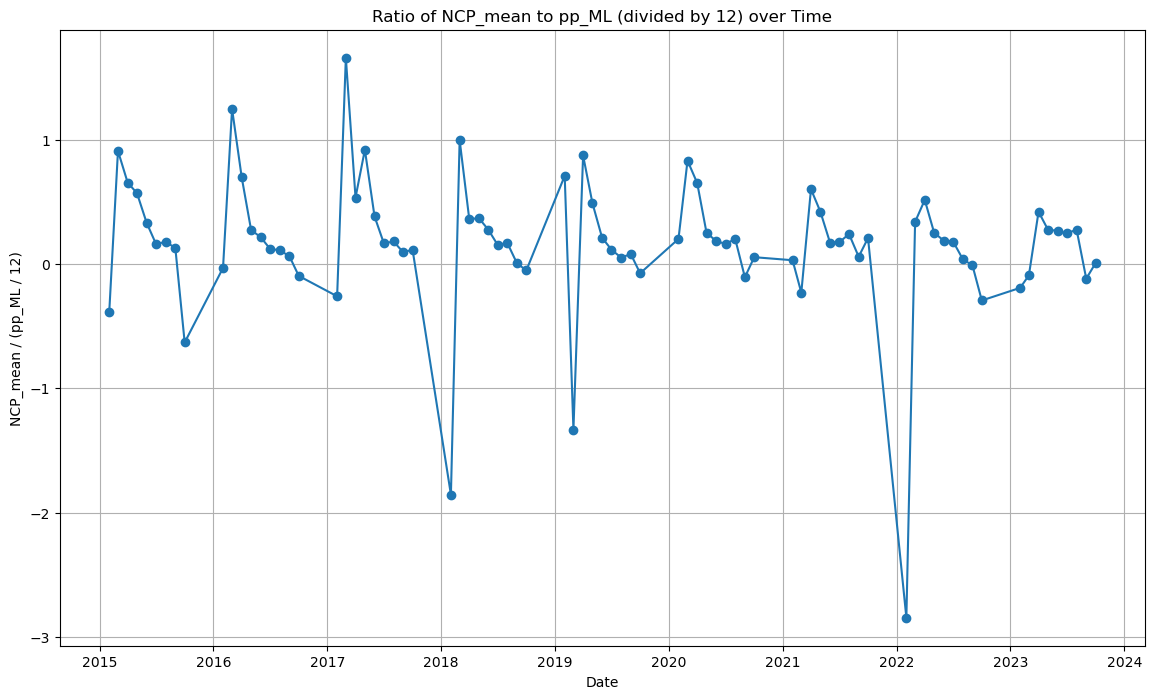

In [40]:
import matplotlib.pyplot as plt

# Compute the ratio: NCP_mean / (pp_ML / 12)
# Filter out rows where pp_ML or NCP_mean is NaN
filtered_data = monthly_time_series.dropna(subset=['pp_ML', 'NCP_mean']).copy()
filtered_data['ratio'] = filtered_data['NCP_mean'] / (filtered_data['pp_ML'] / 12)

# Plot the ratio over time
plt.figure(figsize=(14, 8))
plt.plot(filtered_data['date'], filtered_data['ratio'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('NCP_mean / (pp_ML / 12)')
plt.title('Ratio of NCP_mean to pp_ML (divided by 12) over Time')
plt.grid(True)
plt.show()

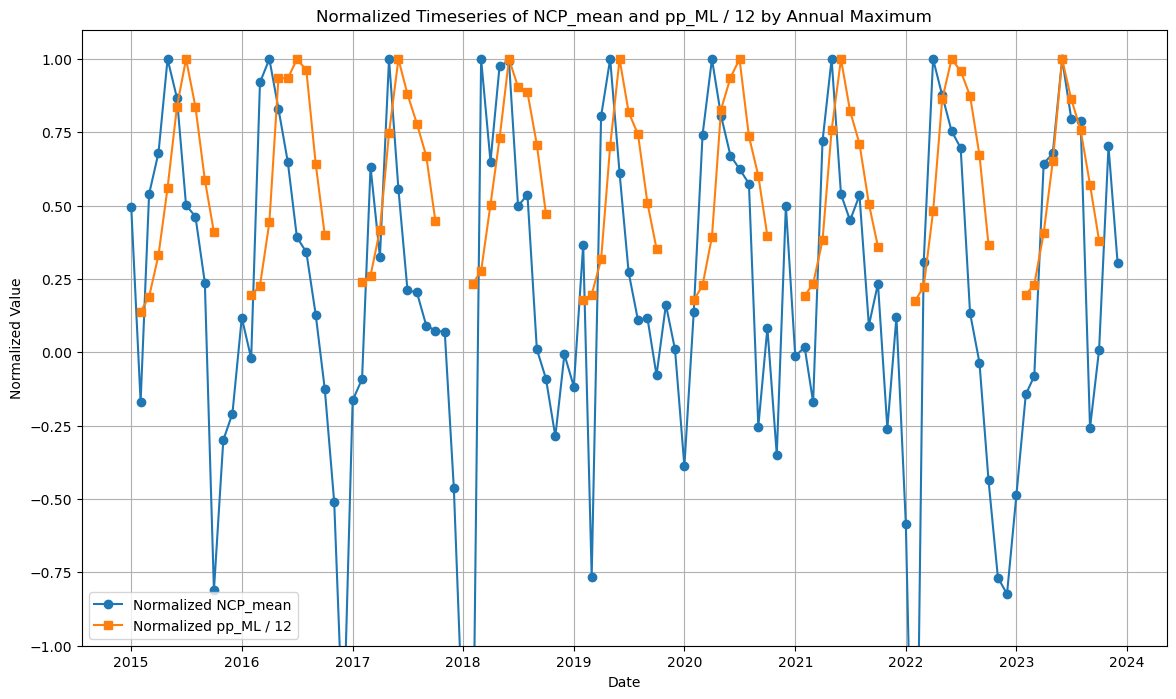

In [47]:
# Add date column to monthly_time_series for plotting
monthly_time_series['date'] = pd.to_datetime(monthly_time_series[['year', 'month']].assign(day=1))

#filter to keep data before 2024
monthly_time_series = monthly_time_series[monthly_time_series['date'] < '2024-01-01']
# Normalize NCP_mean and pp_ML / 12 by the maximum value of each year
monthly_time_series['NCP_normalized'] = monthly_time_series.groupby('year')['NCP_mean'].transform(lambda x: x / x.max())
monthly_time_series['pp_normalized'] = monthly_time_series.groupby('year')['pp_ML'].transform(lambda x: (x / 12) / (x / 12).max())

# Plot the normalized NCP_mean and pp_ML / 12 on the same timeseries
plt.figure(figsize=(14, 8))
plt.plot(monthly_time_series['date'], monthly_time_series['NCP_normalized'], label='Normalized NCP_mean', marker='o')
plt.plot(monthly_time_series['date'], monthly_time_series['pp_normalized'], label='Normalized pp_ML / 12', marker='s')
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.title('Normalized Timeseries of NCP_mean and pp_ML / 12 by Annual Maximum')
#ylimit between 0 and 1
plt.ylim(-1, 1.1)
plt.legend()
plt.grid(True)
plt.show()

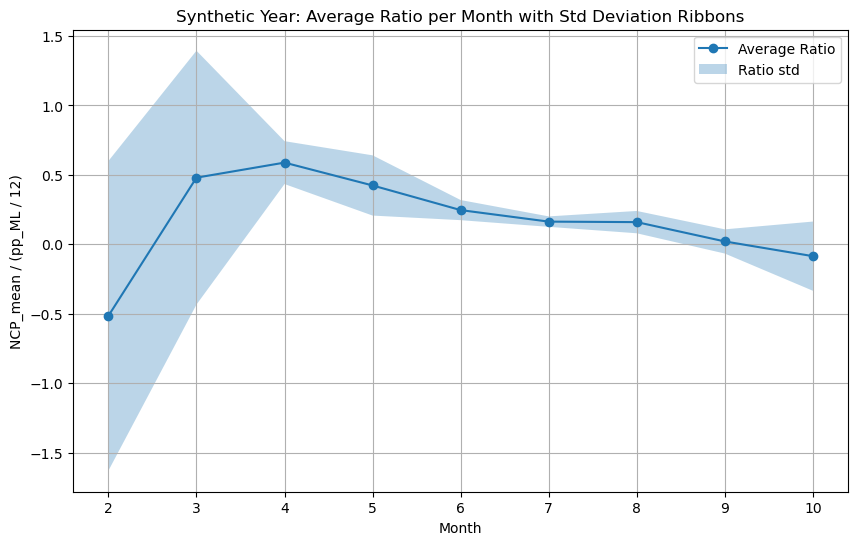

In [46]:
# Compute the ratio for synthetic year
# Filter data where both pp_ML and NCP_mean are not NaN
filtered_ratio_data = monthly_time_series.dropna(subset=['pp_ML', 'NCP_mean']).copy()
filtered_ratio_data['ratio'] = filtered_ratio_data['NCP_mean'] / (filtered_ratio_data['pp_ML'] / 12)

# Group by month and compute mean and std of the ratio
synthetic_year_ratio = filtered_ratio_data.groupby('month').agg({
    'ratio': ['mean', 'std']
}).reset_index()
synthetic_year_ratio.columns = ['month', 'ratio_mean', 'ratio_std']

# Plot the synthetic year for the ratio
plt.figure(figsize=(10, 6))
plt.plot(synthetic_year_ratio['month'], synthetic_year_ratio['ratio_mean'], label='Average Ratio', marker='o')
plt.fill_between(synthetic_year_ratio['month'], 
                 synthetic_year_ratio['ratio_mean'] - synthetic_year_ratio['ratio_std'], 
                 synthetic_year_ratio['ratio_mean'] + synthetic_year_ratio['ratio_std'], 
                 alpha=0.3, label='Ratio std')
plt.xlabel('Month')
plt.ylabel('NCP_mean / (pp_ML / 12)')
plt.title('Synthetic Year: Average Ratio per Month with Std Deviation Ribbons')
plt.legend()
plt.grid(True)
plt.show()

In [77]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Extract month from date
profile_summary_df['month'] = profile_summary_df['date'].dt.month

# Group by float_wmo and month, average pp_ML, and take mean lat/lon
monthly_float_avg = profile_summary_df.groupby(['float_wmo', 'month']).agg({
    'pp_ML': 'mean',
    'latitude': 'mean',
    'longitude': 'mean'
}).reset_index()

# Filter to months 2-10 as per synthetic_year
monthly_float_avg = monthly_float_avg[monthly_float_avg['month'].between(2, 10)]

# Create a figure with subplots for each month
months = sorted(monthly_float_avg['month'].unique())


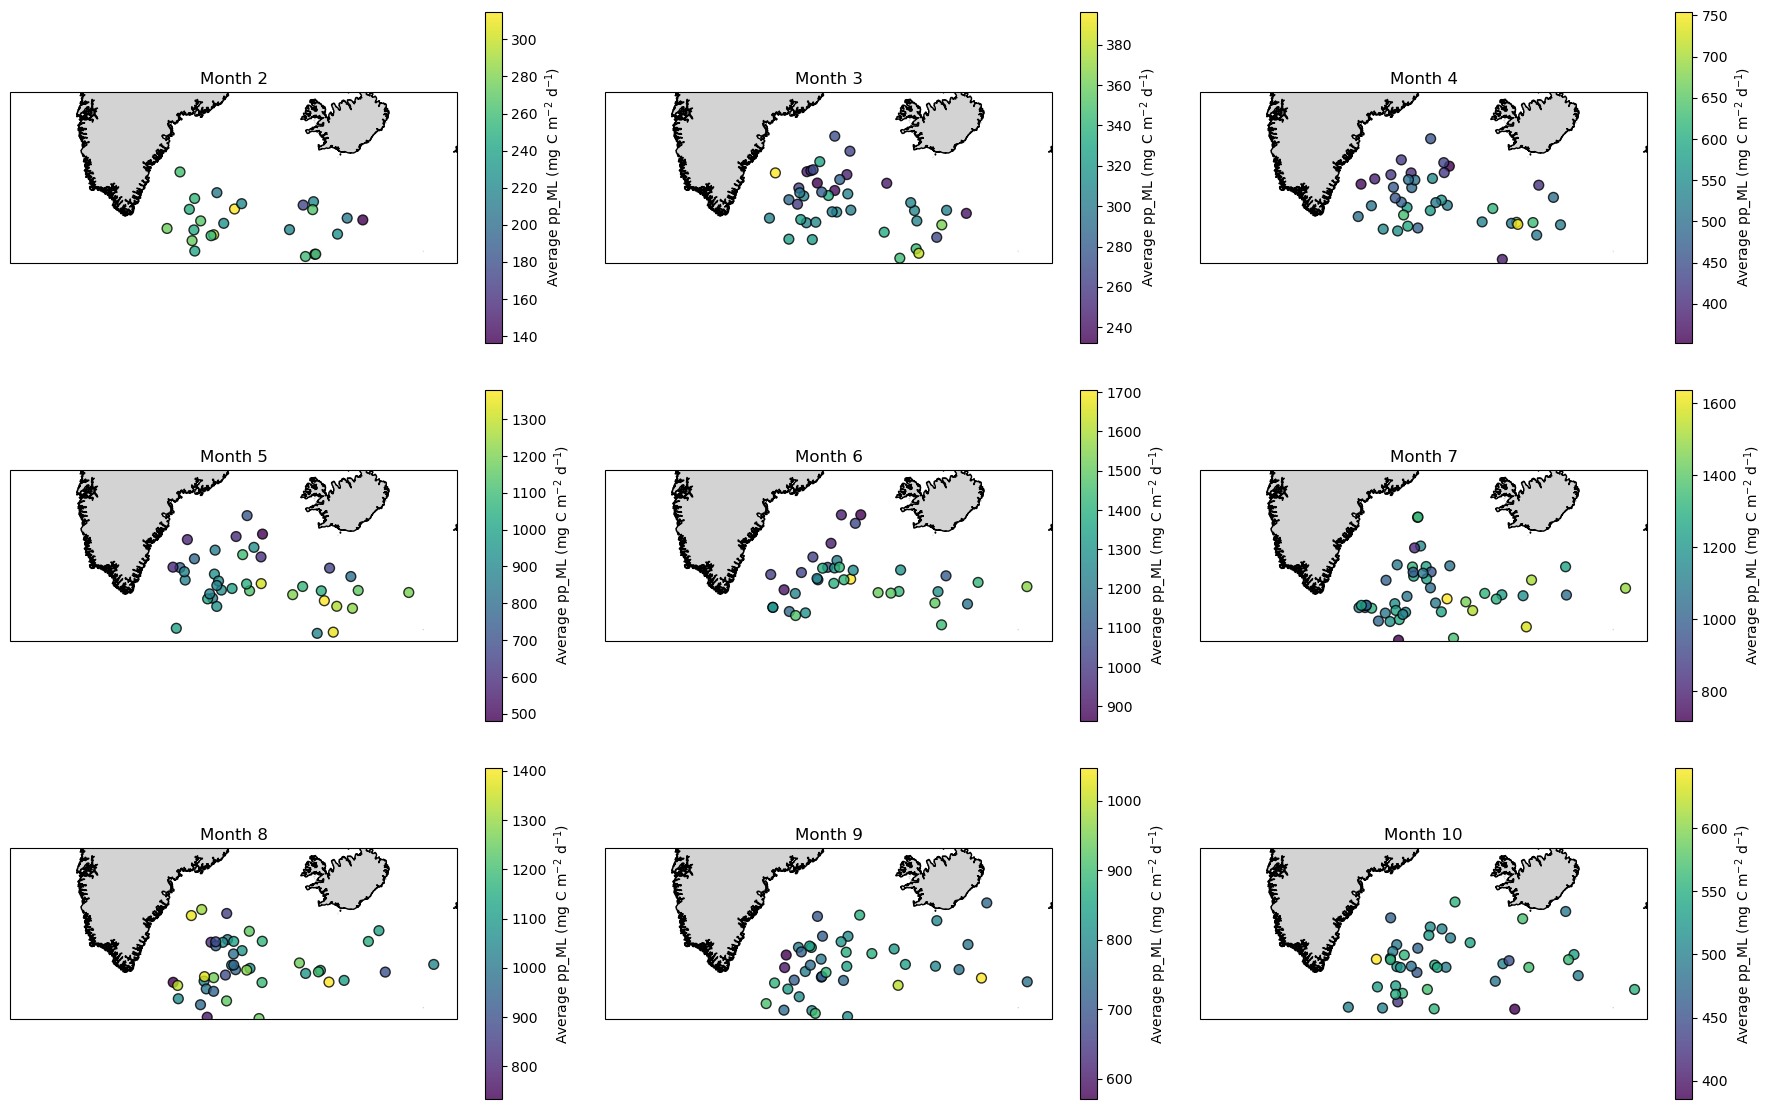

In [82]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Extract month from date
profile_summary_df['month'] = profile_summary_df['date'].dt.month

# Group by float_wmo and month, average pp_ML, and take mean lat/lon
monthly_float_avg = profile_summary_df.groupby(['float_wmo', 'month']).agg({
    'pp_ML': 'mean',
    'latitude': 'mean',
    'longitude': 'mean'
}).reset_index()

# Filter to months 2-10 as per synthetic_year
monthly_float_avg = monthly_float_avg[monthly_float_avg['month'].between(2, 10)]

# Create a figure with subplots for each month
months = sorted(monthly_float_avg['month'].unique())

fig, axes = plt.subplots(3, 3, figsize=(18, 12), subplot_kw={'projection': ccrs.AzimuthalEquidistant(central_latitude=61, central_longitude=-30)})
axes = axes.flatten()

for i, month in enumerate(months):
    ax = axes[i]
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_extent([-55, -10, 58, 65], crs=ccrs.PlateCarree())  # North Atlantic extent
    
    month_data = monthly_float_avg[monthly_float_avg['month'] == month]
    if not month_data.empty:
        sc = ax.scatter(month_data['longitude'], month_data['latitude'], 
                        c=month_data['pp_ML'], cmap='viridis', s=50, edgecolor='k', alpha=0.8,
                        transform=ccrs.PlateCarree())
        ax.set_title(f'Month {month}')
        plt.colorbar(sc, ax=ax, shrink=0.8, label='Average pp_ML (mg C m$^{-2}$ d$^{-1}$)')

plt.tight_layout()
plt.show()

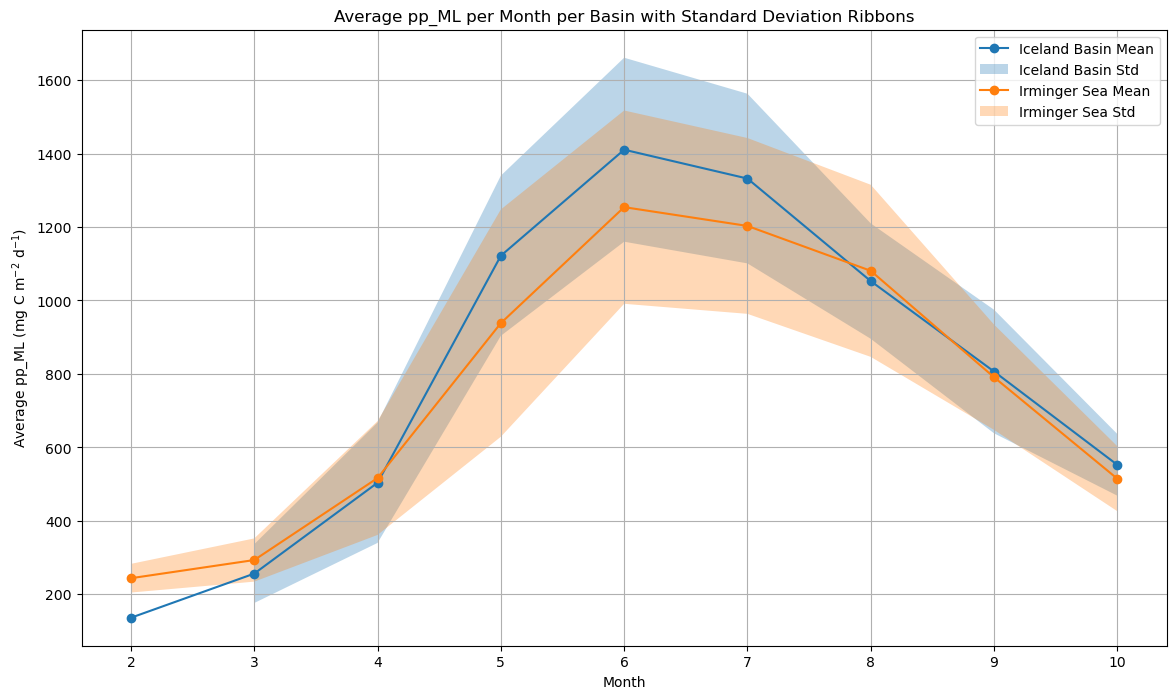

In [84]:
# Define basins based on longitude
# Irminger Sea: longitude <= -20
# Iceland Basin: longitude > -20
profile_summary_df['basin'] = profile_summary_df['longitude'].apply(lambda x: 'Irminger Sea' if x <= -20 else 'Iceland Basin')

# Group by basin and month, average pp_ML and compute std
monthly_avg_basin = profile_summary_df.groupby(['basin', 'month']).agg({
    'pp_ML': ['mean', 'std']
}).reset_index()
monthly_avg_basin.columns = ['basin', 'month', 'pp_ML_mean', 'pp_ML_std']

# Plot average pp_ML per month per basin with std ribbons
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 8))

for basin in monthly_avg_basin['basin'].unique():
    basin_data = monthly_avg_basin[monthly_avg_basin['basin'] == basin]
    ax.plot(basin_data['month'], basin_data['pp_ML_mean'], marker='o', label=f'{basin} Mean')
    ax.fill_between(basin_data['month'], 
                    basin_data['pp_ML_mean'] - basin_data['pp_ML_std'], 
                    basin_data['pp_ML_mean'] + basin_data['pp_ML_std'], 
                    alpha=0.3, label=f'{basin} Std')

ax.set_xlabel('Month')
ax.set_ylabel('Average pp_ML (mg C m$^{-2}$ d$^{-1}$)')
ax.set_title('Average pp_ML per Month per Basin with Standard Deviation Ribbons')
ax.legend()
ax.grid(True)
plt.show()

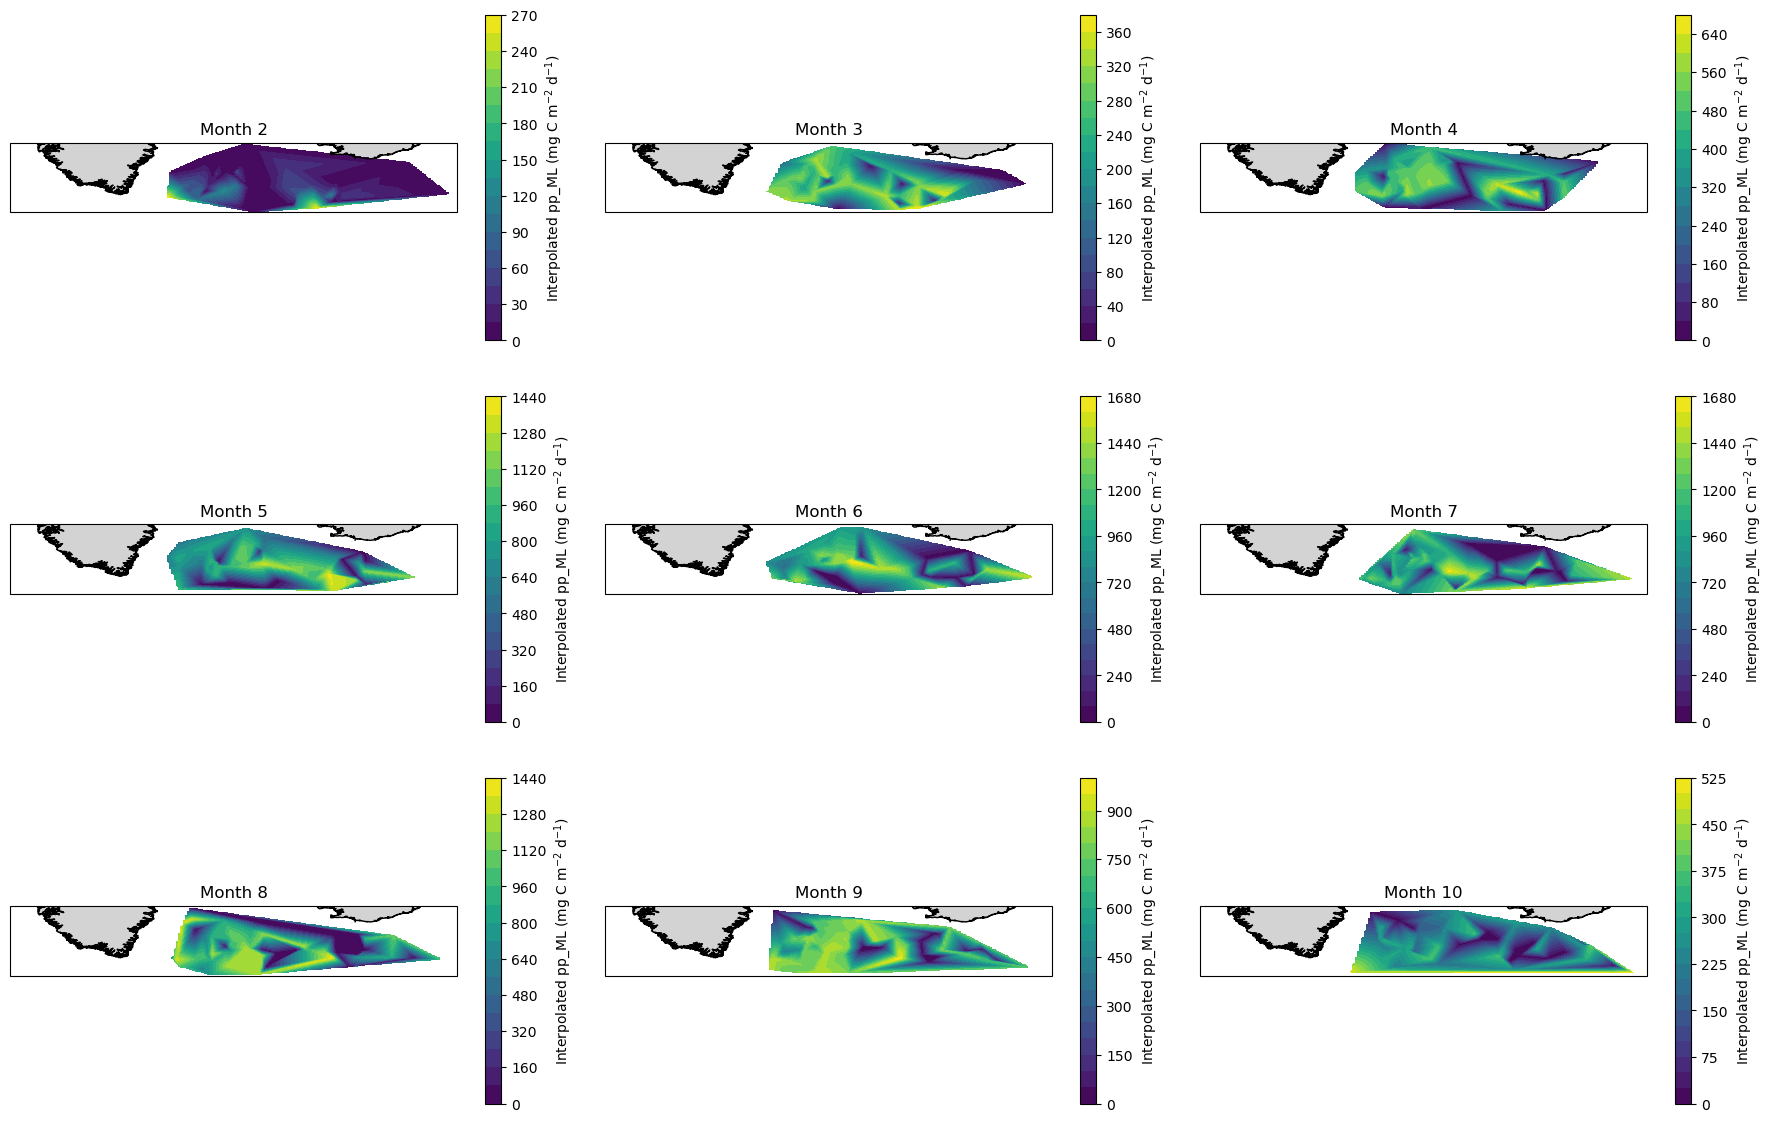

In [50]:
import scipy.interpolate as interp

# Define the grid for interpolation
lon_grid = np.linspace(-55, -10, 200)
lat_grid = np.linspace(58, 65, 100)
lon_mesh, lat_mesh = np.meshgrid(lon_grid, lat_grid)

# Create a new figure with subplots for each month
fig, axes = plt.subplots(3, 3, figsize=(18, 12), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for i, month in enumerate(months):
    ax = axes[i]
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_extent([-55, -10, 58, 65], crs=ccrs.PlateCarree())
    
    month_data = monthly_float_avg[monthly_float_avg['month'] == month]
    if not month_data.empty:
        # Interpolate spatially
        points = (month_data['longitude'].values, month_data['latitude'].values)
        values = month_data['pp_ML'].values
        grid_z = interp.griddata(points, values, (lon_mesh, lat_mesh), method='linear')
        
        # Plot the interpolated field
        cs = ax.contourf(lon_grid, lat_grid, grid_z, cmap='viridis', levels=20, transform=ccrs.PlateCarree())
        plt.colorbar(cs, ax=ax, shrink=0.8, label='Interpolated pp_ML (mg C m$^{-2}$ d$^{-1}$)')
        ax.set_title(f'Month {month}')
    else:
        ax.set_title(f'Month {month} (No Data)')

plt.tight_layout()
plt.show()

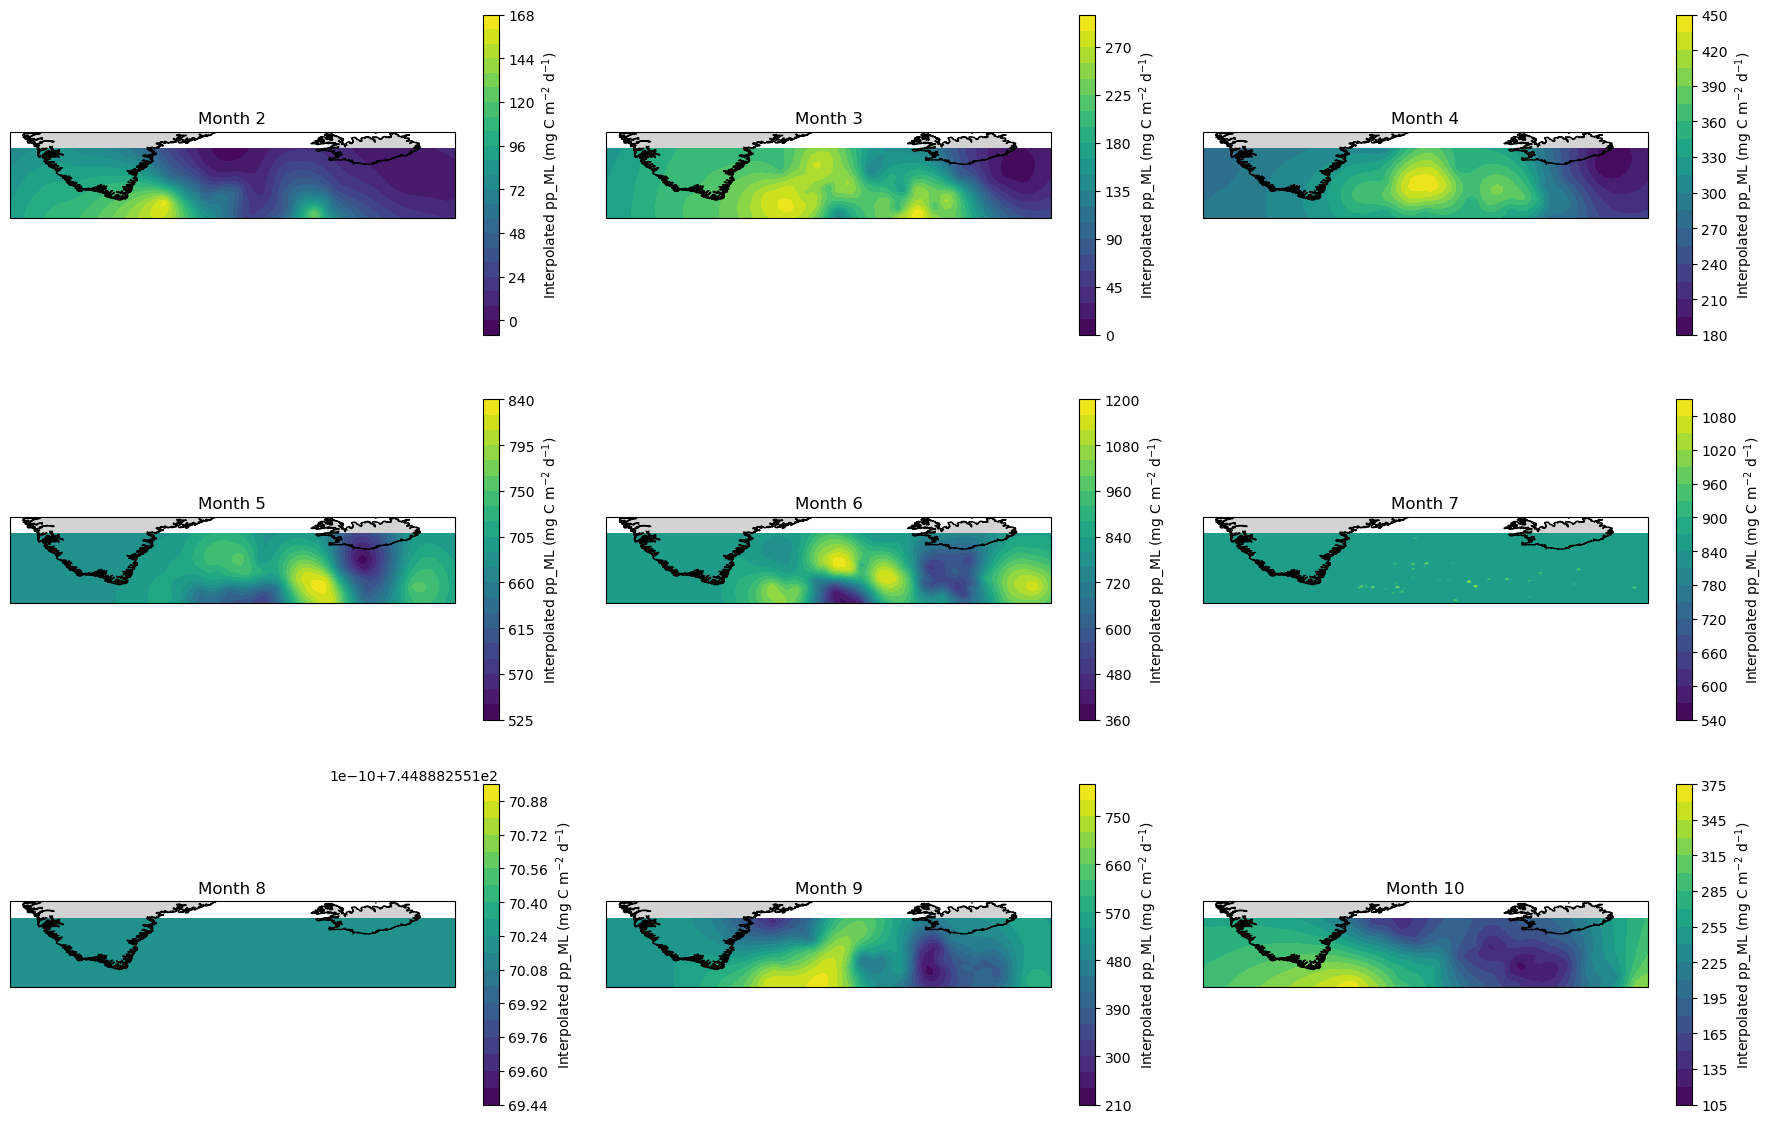

In [52]:
from pykrige.ok import OrdinaryKriging
import numpy as np

# Grid
lon_grid = np.linspace(-55, -10, 200)
lat_grid = np.linspace(58, 65, 100)

fig, axes = plt.subplots(
    3, 3, figsize=(18, 12),
    subplot_kw={'projection': ccrs.PlateCarree()}
)
axes = axes.flatten()

for i, month in enumerate(months):
    ax = axes[i]
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_feature(cfeature.COASTLINE)
    ax.set_extent([-55, -10, 58, 65])

    month_data = monthly_float_avg[
        monthly_float_avg['month'] == month
    ].dropna(subset=['pp_ML'])

    if len(month_data) < 5:
        ax.set_title(f'Month {month} (Too few points)')
        continue

    lons = month_data['longitude'].values
    lats = month_data['latitude'].values
    values = month_data['pp_ML'].values

    OK = OrdinaryKriging(
        lons, lats, values,
        variogram_model='spherical',
        verbose=False,
        enable_plotting=False
    )

    z, ss = OK.execute('grid', lon_grid, lat_grid)

    cs = ax.contourf(
        lon_grid, lat_grid, z,
        levels=20, cmap='viridis',
        transform=ccrs.PlateCarree()
    )

    plt.colorbar(
        cs, ax=ax, shrink=0.8,
        label='Interpolated pp_ML (mg C m$^{-2}$ d$^{-1}$)'
    )

    ax.set_title(f'Month {month}')

plt.tight_layout()
plt.show()


In [55]:
profile_summary_df

date   latitude  longitude       pp_ML  npp_vgpm_ML  \
profile_id                                                              
1901210_166 2016-02-13  58.003000 -38.136000    0.000000          NaN   
1901210_170 2016-03-24  58.416000 -39.896000  341.344588   135.039664   
1901210_172 2016-04-13  58.500000 -39.202000  502.134434   246.834853   
1901210_173 2016-04-23  58.523000 -38.546000  602.173028   372.761716   
1901210_174 2016-05-03  58.720000 -39.087000  846.783927   626.234151   
...                ...        ...        ...         ...          ...   
7902223_52  2025-10-27  61.084361 -30.606907    0.000000          NaN   
7902223_6   2024-09-07  62.330171 -19.602902    0.000000          NaN   
7902223_7   2024-09-08  62.354183 -19.749048    0.000000          NaN   
7902223_8   2024-09-09  62.351090 -19.861938    0.000000          NaN   
7902223_9   2024-09-10  62.327156 -19.961777    0.000000          NaN   

            float_wmo  month  
profile_id                    
1901210_166   1901210      2  
1901210_170   1901210      3  
1901210_172   1901210      4  
1901210_173   1901210      4  
1901210_174   1901210      5  
...               ...    ...  
7902223_52    7902223     10  
7902223_6     7902223      9  
7902223_7     7902223      9  
7902223_8     7902223      9  
7902223_9     7902223      9  

[3858 rows x 7 columns]

In [57]:
# Extract month from date
profile_summary_df['month'] = profile_summary_df['date'].dt.month

# Group by float_wmo and month, average pp_ML, and take mean lat/lon
monthly_float_avg = profile_summary_df.groupby(['float_wmo', 'month']).agg({
    'npp_vgpm_ML': 'mean',
    'latitude': 'mean',
    'longitude': 'mean'
}).reset_index()

# Filter to months 2-10 as per synthetic_year
monthly_float_avg = monthly_float_avg[monthly_float_avg['month'].between(2, 10)]

# Create a figure with subplots for each month
months = sorted(monthly_float_avg['month'].unique())

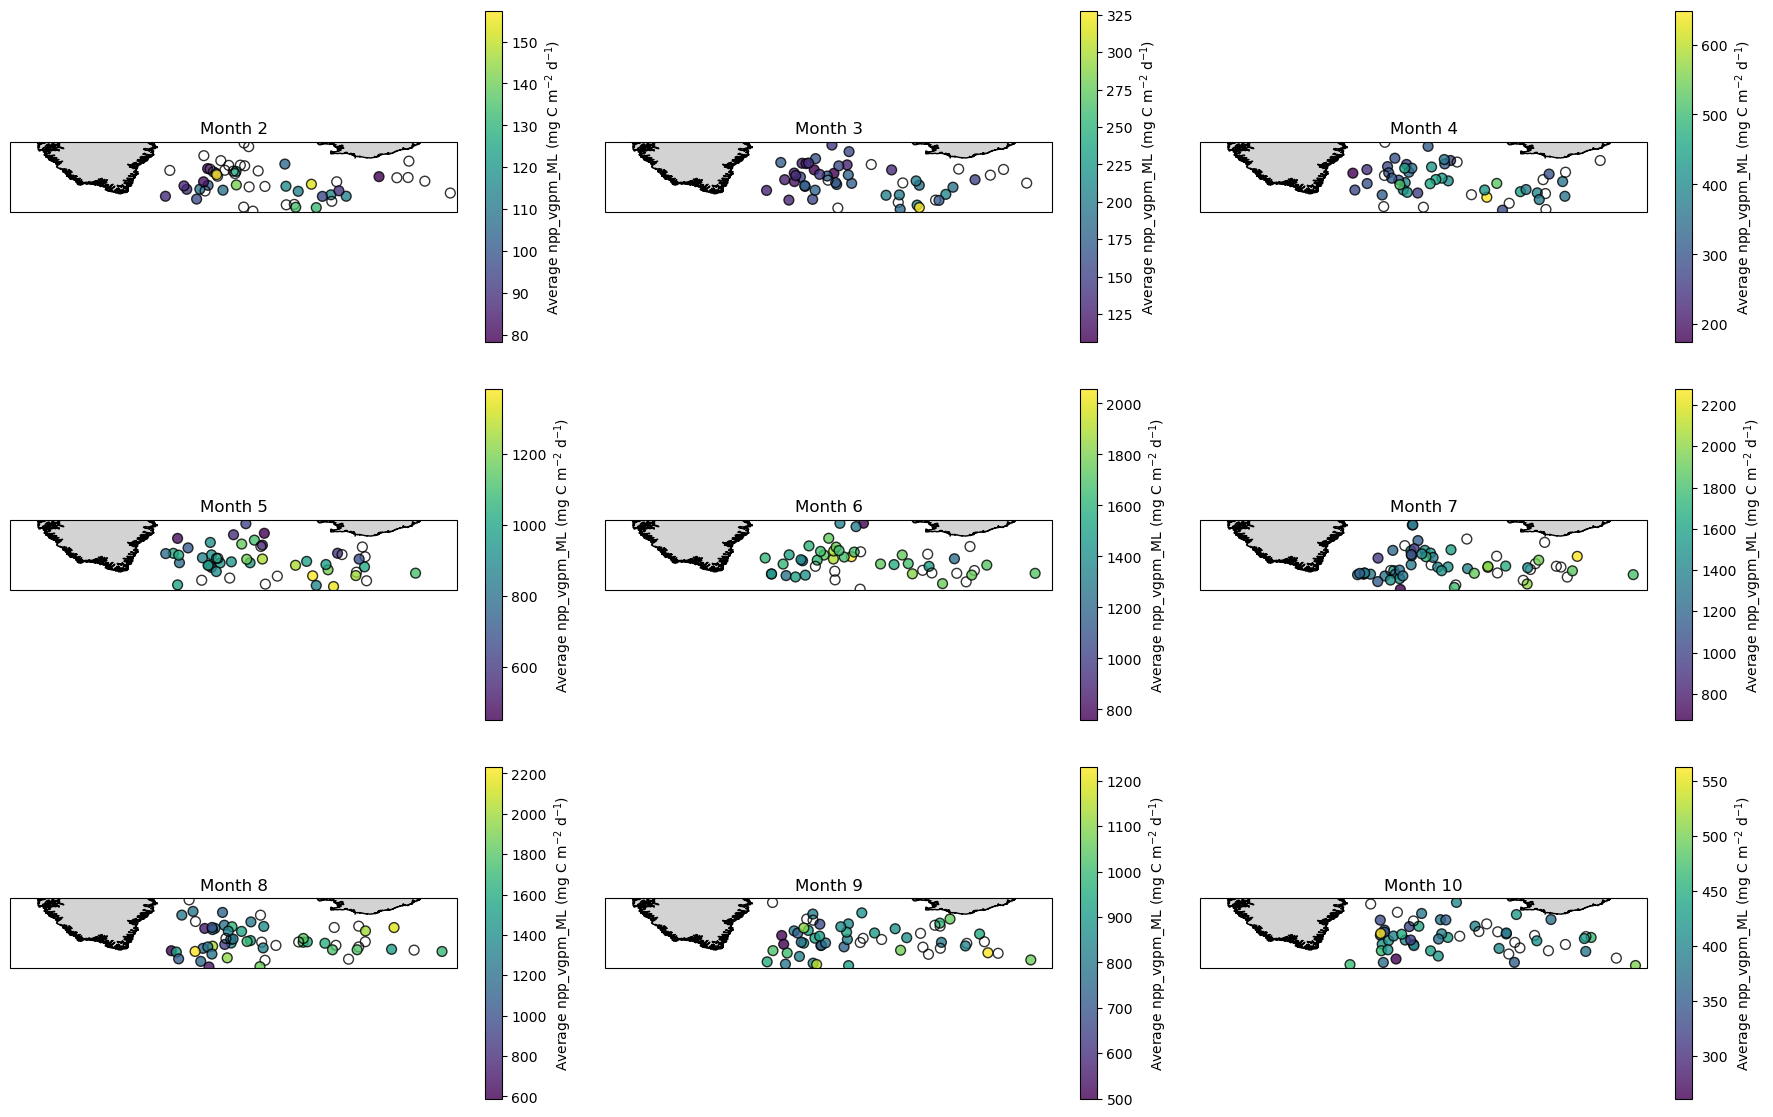

In [58]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for i, month in enumerate(months):
    ax = axes[i]
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_extent([-55, -10, 58, 65], crs=ccrs.PlateCarree())  # North Atlantic extent
    
    month_data = monthly_float_avg[monthly_float_avg['month'] == month]
    if not month_data.empty:
        sc = ax.scatter(month_data['longitude'], month_data['latitude'], 
                        c=month_data['npp_vgpm_ML'], cmap='viridis', s=50, edgecolor='k', alpha=0.8,
                        transform=ccrs.PlateCarree())
        ax.set_title(f'Month {month}')
        plt.colorbar(sc, ax=ax, shrink=0.8, label='Average npp_vgpm_ML (mg C m$^{-2}$ d$^{-1}$)')

plt.tight_layout()
plt.show()